In [1]:
# ------------------------------------------------
# 
# exploratory plots with the xr datasets
# for sil and cc (and their anomaly)
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "009"
tag_sil_1 = ""

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "009"
tag_sil_2 = ""



In [ ]:
# -----------------------------------------
# --- UPDATE FOR AWS:
# # read in files using this format
# import s3fs

# fs = s3fs.S3FileSystem()
# s3path = 's3://cplan/my/file.nc'
# with fs.open(s3path, mode='rb') as fn:
#     tx = xr.open_dataset(fn)
# -----------------------------------------

## Read in data
Read in two sets of simulations. Here, we just read in the xr.Datasets but there are also pd.DataFrames in the same dirs that were computed before emissions accounting was done (for easy/quick testing of different emissions scenarios)

In [2]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))


In [47]:
# --- READ IN COMPILED DATA
datpath_comp = "/home/tykukla/aglime-swap-cdr/scepter/process/data_external"
comp_fn = "kukla-erw_fluxes.csv"
# read in 
df_compile = pd.read_csv(os.path.join(datpath_comp, comp_fn))

### [1a] Line plot of removals vs apprate: 
- Includes lines for both feedstocks and fertilizer regimes
- Includes bar plot of existing values of application flux used in the literature.
- Removals are calculated relative to a no-application baseline. 
- Loss percent is set to zero.

**User decides:**
- CDR variable (e.g., dif, adv, cations, etc.)
- dust radius (constant for both feedstocks)

29 estimates > xmax


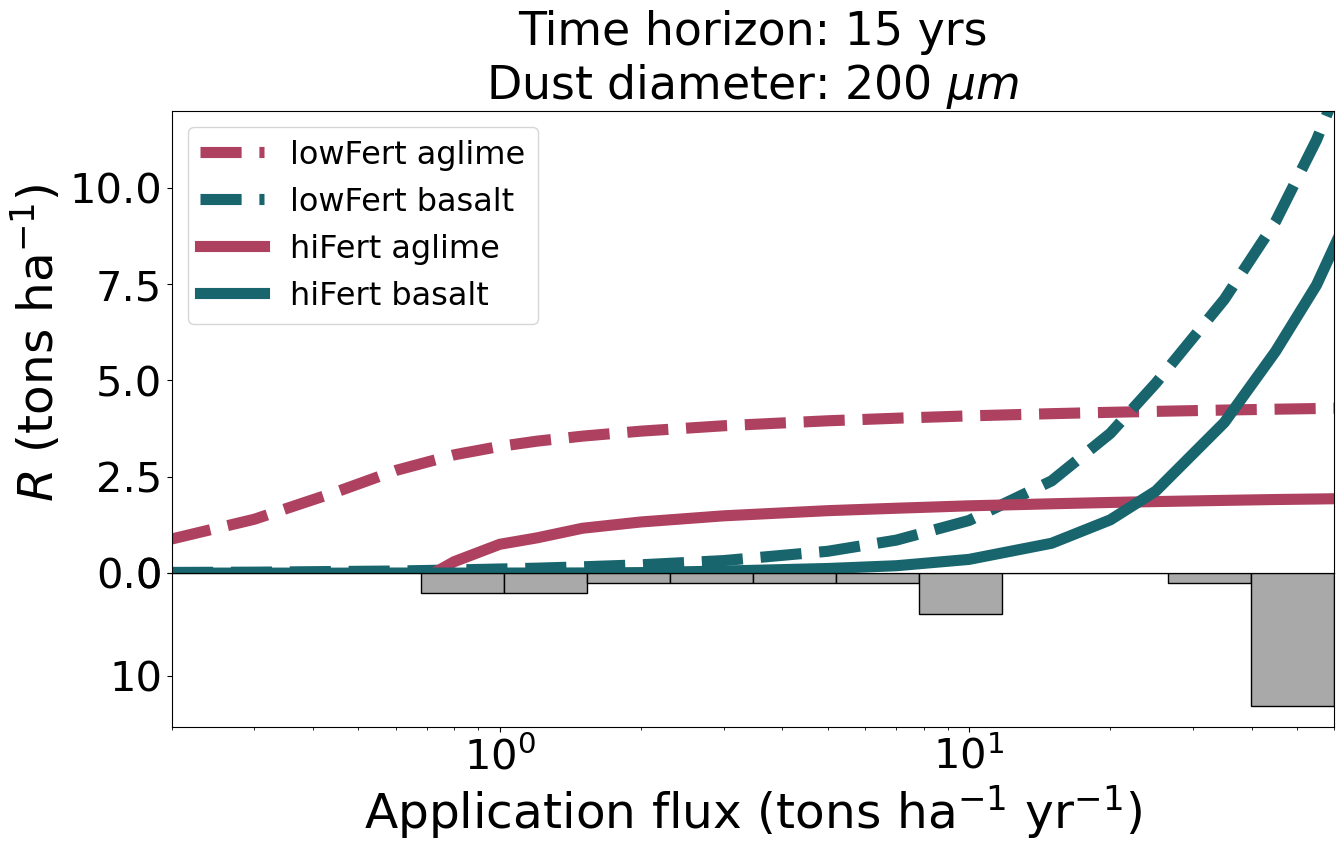

In [42]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif'
rad = 100
logX = True

# pull out the data we want
dssil1_p1 = dssil1.sel(dustrad = rad, loss_percent=0, method='nearest')[cdr_var]
dssil2_p1 = dssil2.sel(dustrad = rad, loss_percent=0, method='nearest')[cdr_var]
dscc1_p1 = dscc1.sel(dustrad = rad, loss_percent=0, method='nearest')[cdr_var]
dscc2_p1 = dscc2.sel(dustrad = rad, loss_percent=0, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p1 = dssil1_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p1 = dssil2_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p1 = dscc1_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p1 = dscc2_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r(np.linspace(0.2, 1.5, 3))   # for line plot
barcol = 'darkgray'
# set fontsizes
fs_xlab = 35     # x title
fs_ylab = 35     # y title
fs_tick = 30     # ticks, bot haxes
fs_title = 33    # plot title
fs_leg = 23      # legend text
# linewidth
lwds = 8
# set plot limits
xmin, xmax = (0.2 if logX else 0), 60
ymin1, ymax1 = 0, 12
ymin2, ymax2 = 0, 15
# hist 
nbars = 15
# *****************************

# make the title text
timehorizon = int(dssil1['time_horizon'].values)
ptext1 = f"Time horizon: {timehorizon} yrs\nDust diameter: {rad*2} {r'$\mu m$'}"

# remove duplicate dust fluxes for a given reference from the external data
df_compile_p1 = df_compile.drop_duplicates(subset=['short reference', 'application_rate_ton_ha_yr']).copy()
# set histogram bin edges in log scale
bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), num=nbars)


# --- SET UP PLOT
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(15, 8))
# adjust space between top and bottom panels
plt.subplots_adjust(hspace=0.)

# CDR vs apprate
# --- fertlevel2
ax1.plot(dscc2_p1['dustrate_ton_ha_yr'], dscc2_p1, label=f'{fertLevel_2}Fert aglime', c=col[0], 
         linewidth=lwds, linestyle='--')
ax1.plot(dssil2_p1['dustrate_ton_ha_yr'], dssil2_p1, label=f'{fertLevel_2}Fert basalt', c=col[1], 
         linewidth=lwds, linestyle='--')
# --- fertlevel1
ax1.plot(dscc1_p1['dustrate_ton_ha_yr'], dscc1_p1, label=f'{fertLevel_1}Fert aglime', c=col[0], linewidth=lwds)
ax1.plot(dssil1_p1['dustrate_ton_ha_yr'], dssil1_p1, label=f'{fertLevel_1}Fert basalt', c=col[1], linewidth=lwds)

# axes and legend
ax1.set_ylabel(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_ylab)
(ax1.set_xscale('log') if logX else "")
ax1.tick_params(axis='both', labelsize=fs_tick)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin1, ymax1)
ax1.set_title(ptext1, fontsize=fs_title)
ax1.legend(fontsize=fs_leg, loc='upper left')
# histogram
ax2.hist(df_compile_p1['application_rate_ton_ha_yr'], bins=bin_edges, range=(xmin,xmax), color=barcol, edgecolor='k')
ax2.set_xlabel(r"Application flux $(\text{tons}\ \text{ha}^{-1}\ \text{yr}^{-1})$", fontsize=fs_xlab)
ax2.tick_params(axis='both', labelsize=fs_tick)
(ax2.set_xscale('log') if logX else "")
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymax2,ymin2)

# number of literature estimates off the plot
print(f'{len(df_compile_p1[df_compile_p1['particle_diameter_um'] > xmax])} estimates > xmax')

----
### [1b] Line plot of removals vs dust radius: 
- Includes lines for both feedstocks and fertilizer regimes
- Includes bar plot of existing values of dust radii used in the literature.
- Removals are calculated relative to a no-application baseline. 
- Loss percent is set to zero.

**User decides:**
- CDR variable (e.g., dif, adv, cations, etc.)
- apprate (constant for both feedstocks)

12 estimates > xmax


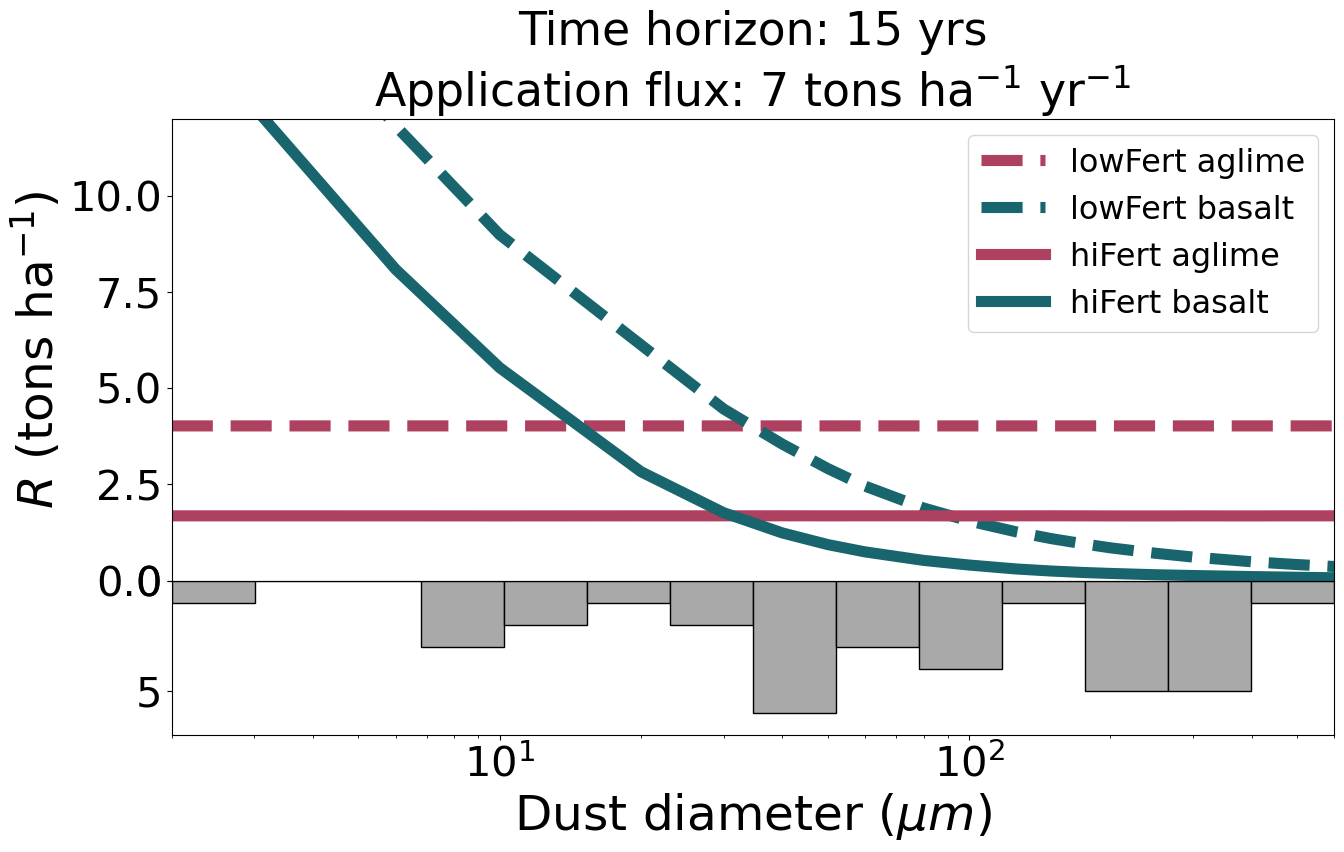

In [43]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif'
apprate = 7
logX = True

# pull out the data we want
dssil1_p2 = dssil1.sel(dustrate_ton_ha_yr = apprate, loss_percent=0, method='nearest')[cdr_var]
dssil2_p2 = dssil2.sel(dustrate_ton_ha_yr = apprate, loss_percent=0, method='nearest')[cdr_var]
dscc1_p2 = dscc1.sel(dustrate_ton_ha_yr = apprate, loss_percent=0, method='nearest')[cdr_var]
dscc2_p2 = dscc2.sel(dustrate_ton_ha_yr = apprate, loss_percent=0, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p2 = dssil1_p2.interpolate_na(dim='dustrad', method='linear').copy()
dssil2_p2 = dssil2_p2.interpolate_na(dim='dustrad', method='linear').copy()
dscc1_p2 = dscc1_p2.interpolate_na(dim='dustrad', method='linear').copy()
dscc2_p2 = dscc2_p2.interpolate_na(dim='dustrad', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r(np.linspace(0.2, 1.5, 3))   # for line plot
barcol = 'darkgray'
# set fontsizes
fs_xlab = 35     # x title
fs_ylab = 35     # y title
fs_tick = 30     # ticks, bot haxes
fs_title = 33    # plot title
fs_leg = 23      # legend text
# linewidth
lwds = 8
# set plot limits
xmin, xmax = (2 if logX else 0), 600
ymin1, ymax1 = 0, 12
ymin2, ymax2 = 0, 7
# hist 
nbars = 15
# *****************************

# make the title text
timehorizon = int(dssil1['time_horizon'].values)
ptext2 = f"Time horizon: {timehorizon} yrs\nApplication flux: {int(apprate)} {r'$\text{tons}\ \text{ha}^{-1}\ \text{yr}^{-1}$'}"

# remove duplicate dust fluxes for a given reference from the external data
df_compile_p2 = df_compile.drop_duplicates(subset=['short reference', 'particle_diameter_um']).copy()
# set histogram bin edges in log scale
bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), num=nbars)


# --- SET UP PLOT
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(15, 8))
# adjust space between top and bottom panels
plt.subplots_adjust(hspace=0.)

# CDR vs apprate
# --- fertlevel2
ax1.plot(dscc2_p2['dustrad']*2, dscc2_p2, label=f'{fertLevel_2}Fert aglime', c=col[0], 
         linewidth=lwds, linestyle='--')
ax1.plot(dssil2_p2['dustrad']*2, dssil2_p2, label=f'{fertLevel_2}Fert basalt', c=col[1], 
         linewidth=lwds, linestyle='--')
# --- fertlevel1
ax1.plot(dscc1_p2['dustrad']*2, dscc1_p2, label=f'{fertLevel_1}Fert aglime', c=col[0], linewidth=lwds)
ax1.plot(dssil1_p2['dustrad']*2, dssil1_p2, label=f'{fertLevel_1}Fert basalt', c=col[1], linewidth=lwds)
(ax1.set_xscale('log') if logX else "")

# axes and legend
ax1.set_ylabel(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_ylab)
ax1.tick_params(axis='both', labelsize=fs_tick)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin1, ymax1)
ax1.set_title(ptext2, fontsize=fs_title)
ax1.legend(fontsize=fs_leg, loc='upper right')
# histogram (divide particle diam by 2 to get radius)
ax2.hist(df_compile_p2['particle_diameter_um'], bins=bin_edges, range=(xmin,xmax), color=barcol, edgecolor='k')
ax2.set_xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
ax2.tick_params(axis='both', labelsize=fs_tick)
(ax2.set_xscale('log') if logX else "")
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymax2,ymin2)

# number of literature estimates off the plot
print(f'{len(df_compile_p2[df_compile_p2['particle_diameter_um'] > xmax])} estimates > xmax')

----
### [2] Downstream loss, apprate contour plots:
- Silicate and CC removals for high and low fert
- Removals are calculated relative to a no-application baseline. 

**User decides:**
- CDR variable (e.g., dif, adv, cations, etc.)
- dustrad (constant for both feedstocks)
- which fertlevels to show (1, 2, or both)
- whether or not the x-axis should be log-scaled

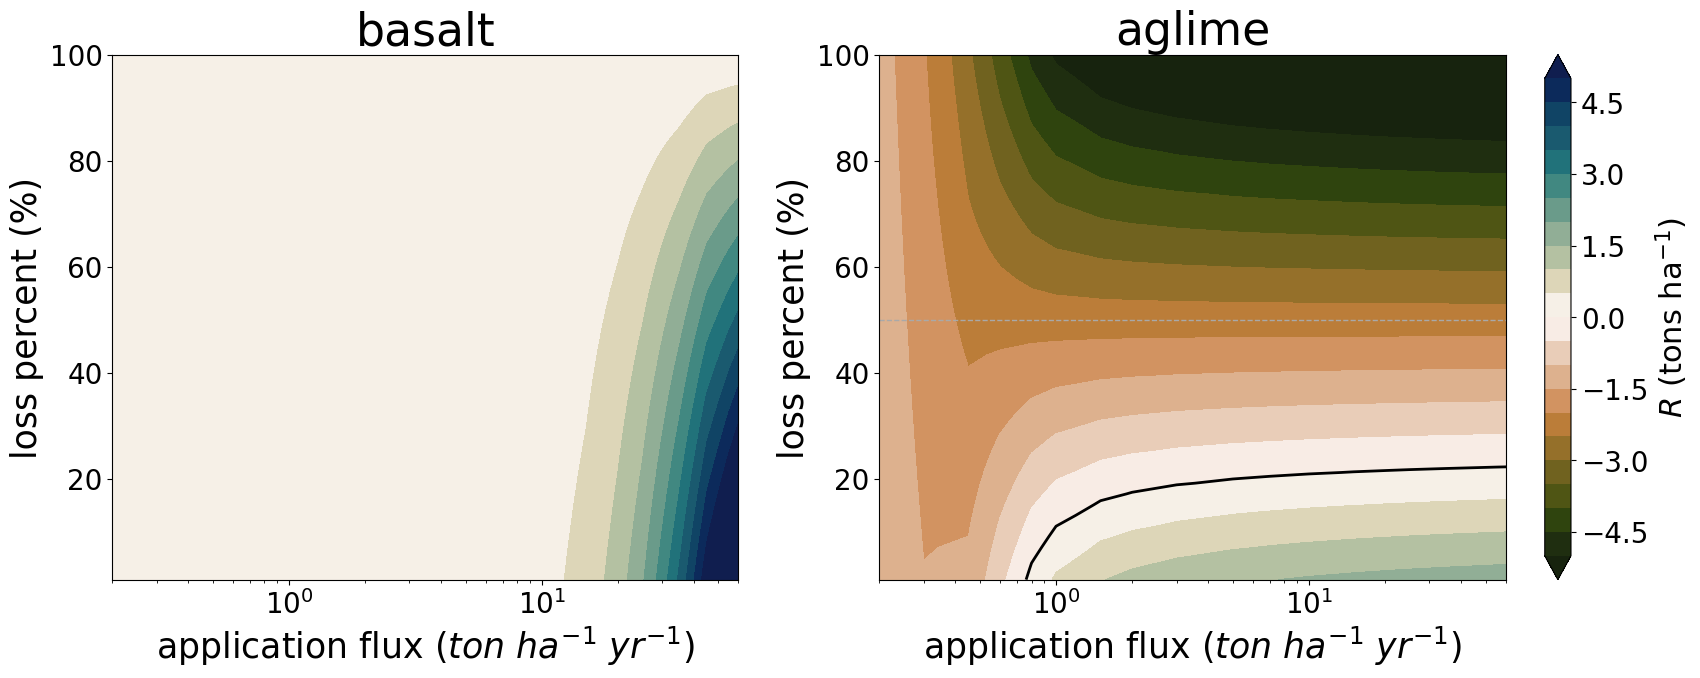

In [44]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_adv'
rad = 100
fertlevel_show = 1   # [1 | 2 | 12]
logX = True

# pull out the data we want
dssil1_p3 = dssil1.sel(dustrad = rad, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(dustrad = rad, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(dustrad = rad, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(dustrad = rad, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.tarn
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.2 if logX else 0), 60
xmin, xmax = 0.2, 60
ymin, ymax = 0, 100
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrate_ton_ha_yr'].values
y1sil = dssil1_p3['loss_percent'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrate_ton_ha_yr'].values
y1cc = dscc1_p3['loss_percent'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrate_ton_ha_yr'].values
y2sil = dssil2_p3['loss_percent'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrate_ton_ha_yr'].values
y2cc = dscc1_p3['loss_percent'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    if logX:
        plt.xscale('log')
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    if logX:
        plt.xscale('log')
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    plt.xlim(xmin, xmax)

----
## [3] Sil-Lime swap with break-even line for both ferts
- colormap should be different from above (to indicate removal vs netCDR)

**User decides:**
- loss rate to apply (the loss rate applies to cc and silicate)
- feedstock (should be silicate if you really want the swap)
- the CDR calculation metric (should be `netR` though..)
- if x and y should be log

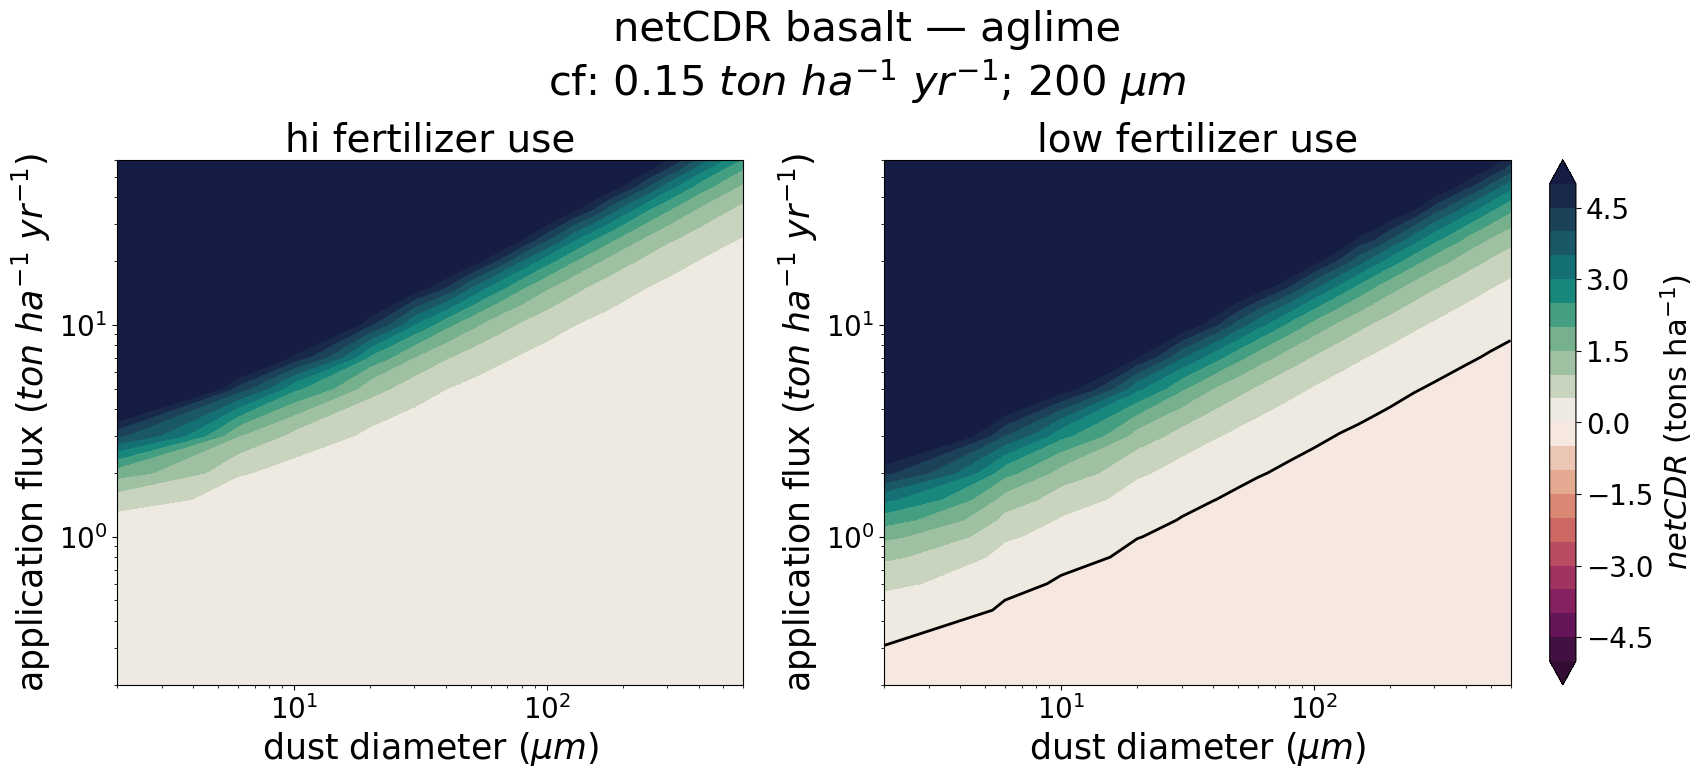

In [45]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_adv' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'netR_noNeg'
logX = True
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = dsanom2_p4['dustrad'].values
y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom2_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom2_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


----
## [4] R and E contour plots (emissions also matter!)
**User decides:**
- feedstock
- fertilization level
- loss rate to apply (the loss rate applies to cc and silicate)
- the R and E variables to use
- whether x and y are log

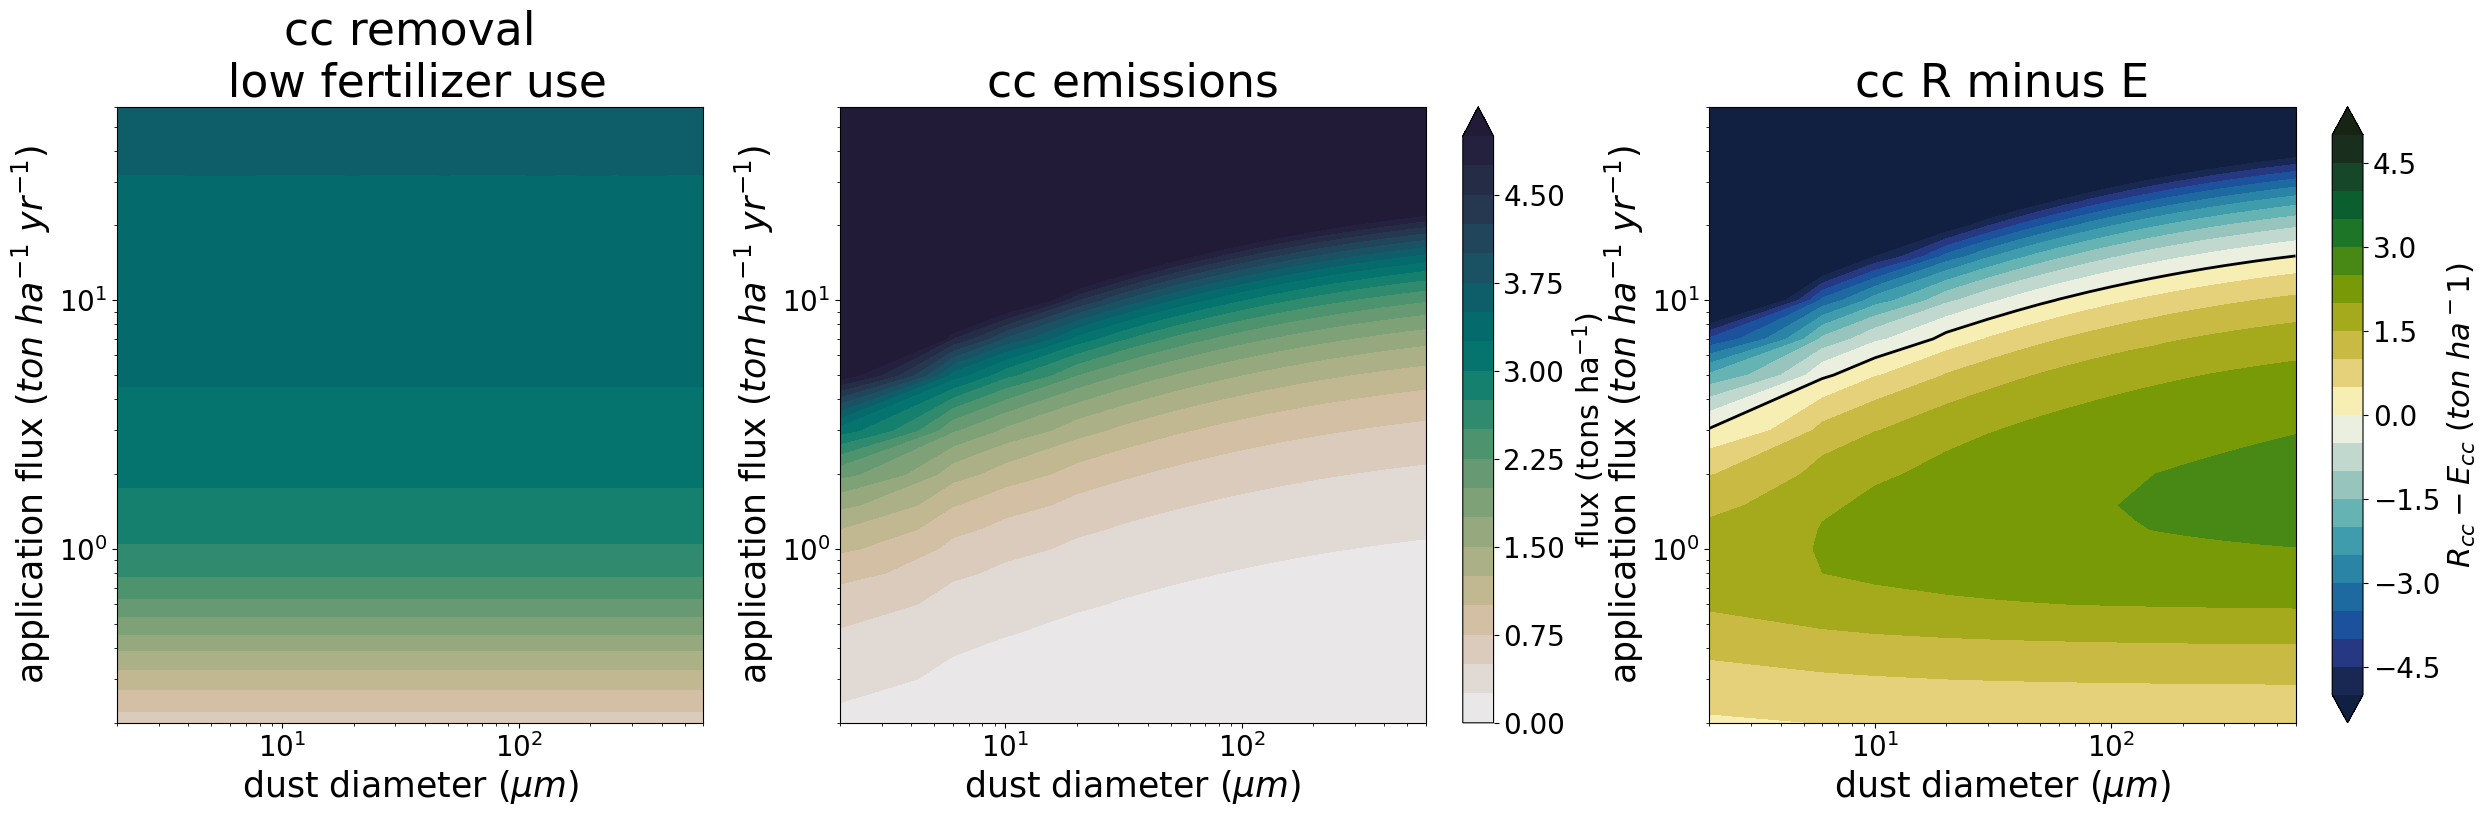

In [46]:
fs_dict = {'cc': [dscc1, dscc2], 'sil': [dssil1, dssil2]}
thisfertlevel = 2   # [1 | 2]
# --- PLOT --------------------
# set data conditions
feedstock_fromDict = "cc"   # ['sil' or 'cc' (per fs_dict above)]
Rvar = 'cdr_dif'  # 'co2pot_tot_tonHa_totcat'
Evar = 'E_total_tonCO2_ha'
loss_percent = 10
logX = True
logY = True

# pull out the data we want
dsfs = fs_dict[feedstock_fromDict][thisfertlevel-1]
dsR = dsfs.sel(loss_percent = loss_percent, method='nearest')[Rvar]
dsE = dsfs.sel(loss_percent = loss_percent, method='nearest')[Evar]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dsR = dsR.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsE = dsE.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col_RE = cmo.rain
col_RmE = cmo.delta
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
# [R and E]
cmin, cmax = 0, 5
cbar_extend = "max"    # both, max, or min
# [R minus E]
cminM, cmaxM = -5, 5
cbar_extendM = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [removals]
x1 = dsR['dustrad'].values
y1 = dsR['dustrate_ton_ha_yr'].values
# [emissions]
x2 = dsE['dustrad'].values
y2 = dsE['dustrate_ton_ha_yr'].values

# set the cbar labels
if feedstock_fromDict == "cc":
    fslab = "cc"
else:
    fslab = "sil"

# make titles
if thisfertlevel == 1:
    tfert = fertLevel_1
else:
    tfert = fertLevel_2
Rtitle = f"{fslab} removal\n {tfert} fertilizer use"
Etitle = f" \n{fslab} emissions"
RmEtitle = f" \n{fslab} R minus E"

# --- SET UP PLOT
spec = GridSpec(ncols=3, nrows=1, hspace=0.2, width_ratios=[0.8, 1, 1])
plt.figure(figsize=(30,8))

# --- fs removals
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsR.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col_RE, vmin=cmin, vmax=cmax, extend=cbar_extend)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(Rtitle, fontsize=fs_title)
if logX:
    plt.xscale('log')
if logY:
    plt.yscale('log')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fs emissions
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsE.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col_RE, vmin=cmin, vmax=cmax, extend=cbar_extend)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(Etitle, fontsize=fs_title)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"flux $(\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)

# --- fs R minus E 
ax = plt.subplot(spec[2])
contour = plt.contourf(x2*2,y2,(dsR-dsE).transpose(), 
                        levels=np.linspace(cminM, cmaxM, 21), cmap = col_RmE, vmin=cminM, vmax=cmaxM, extend=cbar_extendM)
contour_line = plt.contour(x2*2,y2,(dsR-dsE).transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(RmEtitle, fontsize=fs_title)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(fr'$R_{{{fslab}}}-E_{{{fslab}}}$ $(ton\ ha^{-1})$', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)



----
## [5] Breakeven line for different accounting choices
Accounting choices matter too!
- single contour line (at breakeven) for each of four accounting choices
- Both fert levels included

**User decides:**
- feedstock
- loss rate to apply (the loss rate applies to cc and silicate)
- Type of cdr to plot
- whether to use log x and/or y

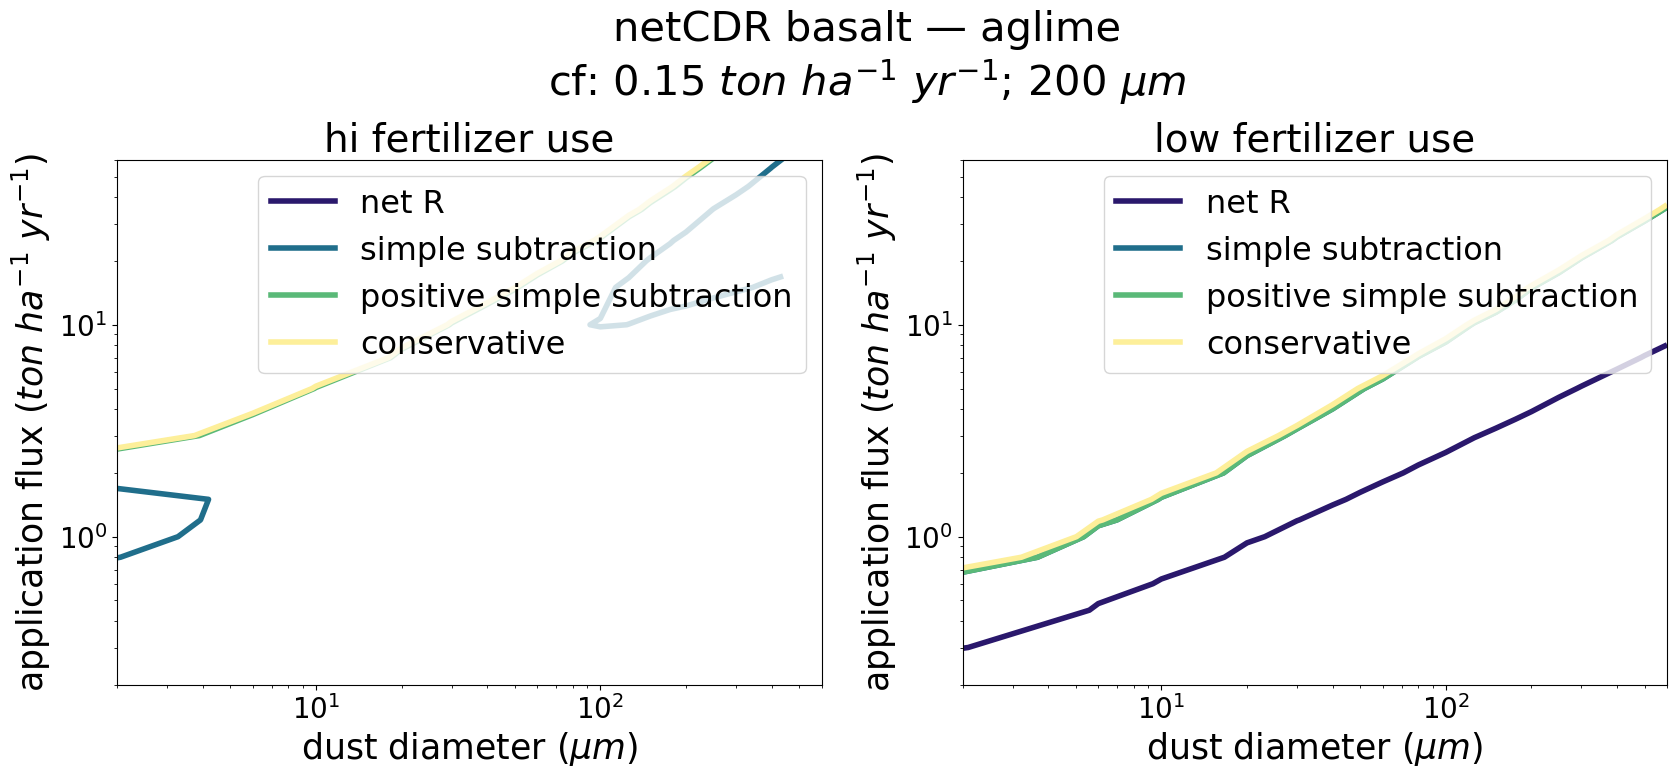

In [47]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}

# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c3 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c4 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c3 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c4 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrad', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrad', method='linear').copy()
ds1_c3 = ds1_c3.interpolate_na(dim='dustrad', method='linear').copy()
ds1_c4 = ds1_c4.interpolate_na(dim='dustrad', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrad', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrad', method='linear').copy()
ds2_c3 = ds2_c3.interpolate_na(dim='dustrad', method='linear').copy()
ds2_c4 = ds2_c4.interpolate_na(dim='dustrad', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.haline(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# ... c3
x1c3 = ds1_c3['dustrad'].values
y1c3 = ds1_c3['dustrate_ton_ha_yr'].values
# ... c4
x1c4 = ds1_c4['dustrad'].values
y1c4 = ds1_c4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values
# ... c3
x2c3 = ds2_c3['dustrad'].values
y2c3 = ds2_c3['dustrate_ton_ha_yr'].values
# ... c4
x2c4 = ds2_c4['dustrad'].values
y2c4 = ds2_c4['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
contour_line2 = plt.contour(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
contour_line3 = plt.contour(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
contour_line4 = plt.contour(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
contour_line2 = plt.contour(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
contour_line3 = plt.contour(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
contour_line4 = plt.contour(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])

plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


### !! WIP !! as above, but w/ fill

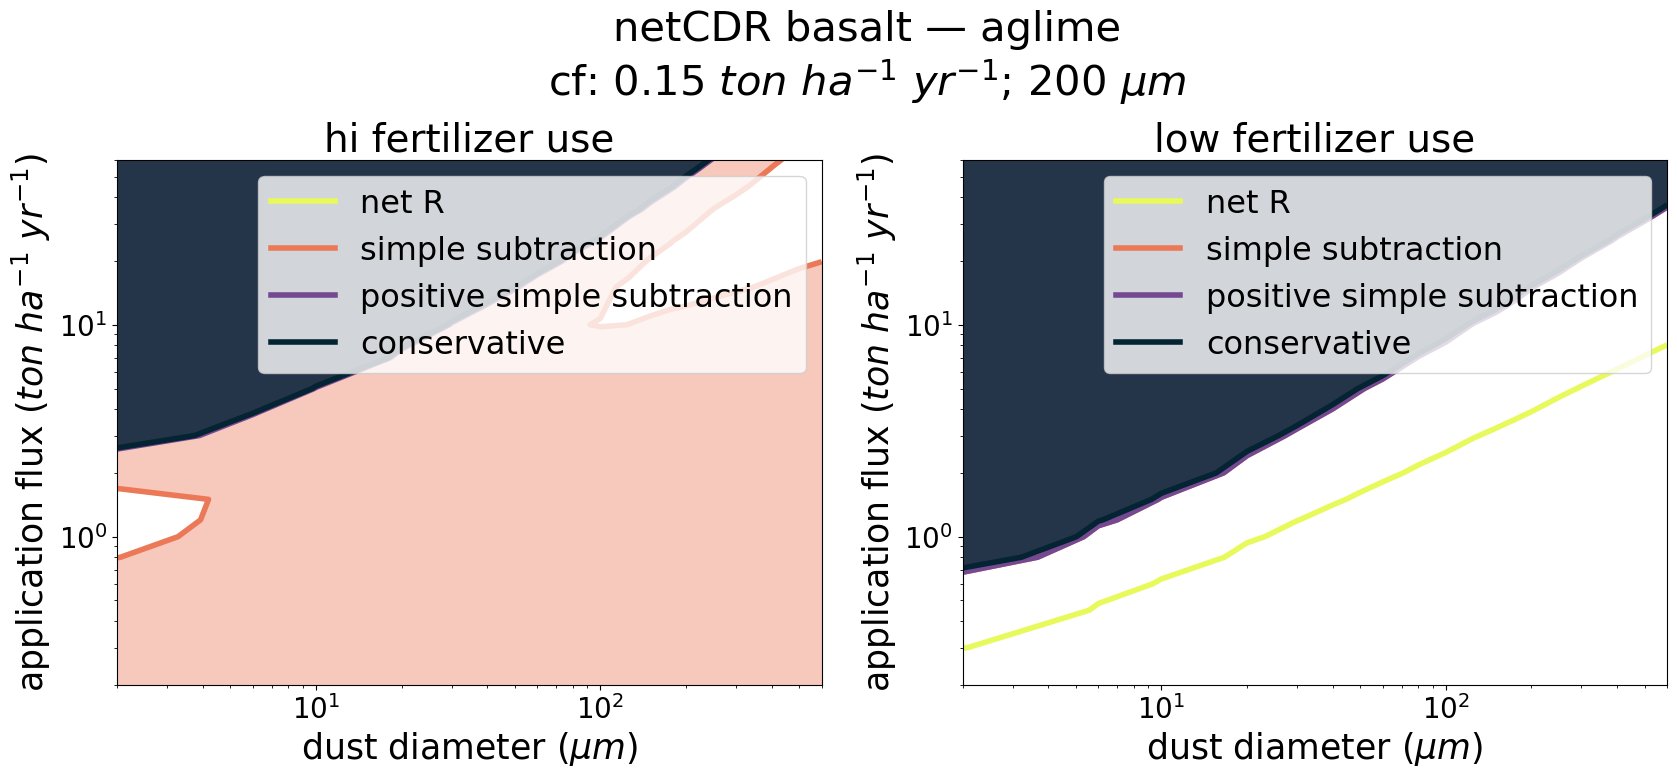

In [48]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}


# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c3 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c4 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c3 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c4 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c3 = ds1_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c4 = ds1_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c3 = ds2_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c4 = ds2_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# ... c3
x1c3 = ds1_c3['dustrad'].values
y1c3 = ds1_c3['dustrate_ton_ha_yr'].values
# ... c4
x1c4 = ds1_c4['dustrad'].values
y1c4 = ds1_c4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values
# ... c3
x2c3 = ds2_c3['dustrad'].values
y2c3 = ds2_c3['dustrate_ton_ha_yr'].values
# ... c4
x2c4 = ds2_c4['dustrad'].values
y2c4 = ds2_c4['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
# contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors='black', alpha=0.2)
contourf2 = plt.contourf(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0,ds1_c2.transpose().max()], colors=col[1:], alpha=0.4)
contourf3 = plt.contourf(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0,ds1_c3.transpose().max()], colors=col[2:], alpha=0.6)
contourf4 = plt.contourf(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0,ds1_c4.transpose().max()], colors=col[3:], alpha=0.8)
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
contour_line2 = plt.contour(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
contour_line3 = plt.contour(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
contour_line4 = plt.contour(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
# contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors='black', alpha=0.2)
contourf2 = plt.contourf(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0,ds2_c2.transpose().max()], colors=col[1:], alpha=0.4)
contourf3 = plt.contourf(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0,ds2_c3.transpose().max()], colors=col[2:], alpha=0.6)
contourf4 = plt.contourf(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0,ds2_c4.transpose().max()], colors=col[3:], alpha=0.8)
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
contour_line2 = plt.contour(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
contour_line3 = plt.contour(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
contour_line4 = plt.contour(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])

plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


----
## [6] As above but layering the contours in 1 at a time
Accounting choices matter too!
- single contour line (at breakeven) for each of four accounting choices
- Both fert levels included

**User decides:**
- feedstock
- loss rate to apply (the loss rate applies to cc and silicate)
- Type of cdr to plot
- whether to use log x and/or y

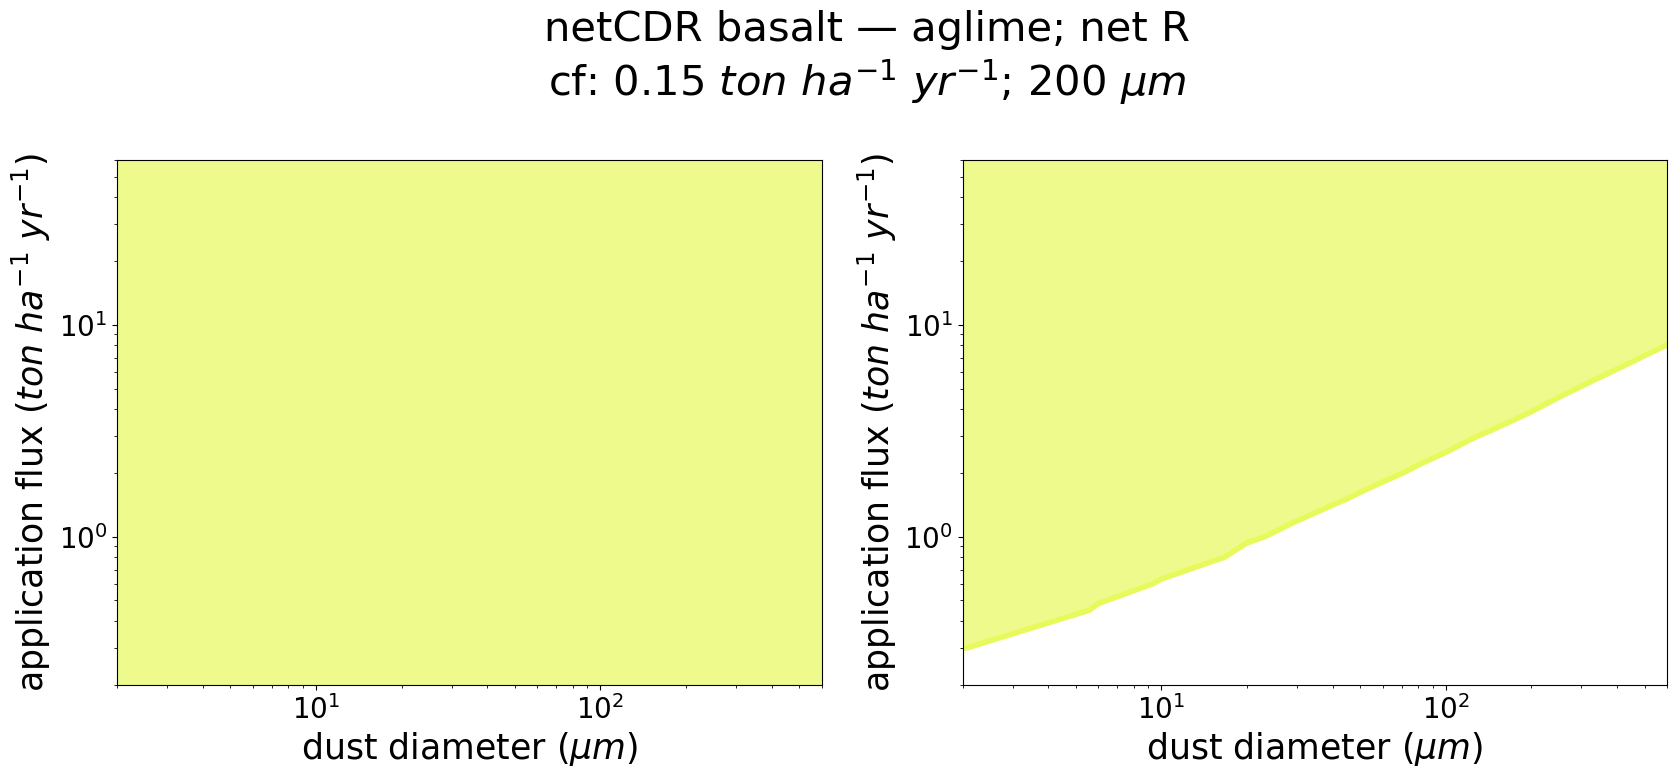

In [49]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}


# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors=col[0:], alpha=0.7)
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime; {list(cdr_calc.keys())[0]}\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors=col[0:], alpha=0.7)
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


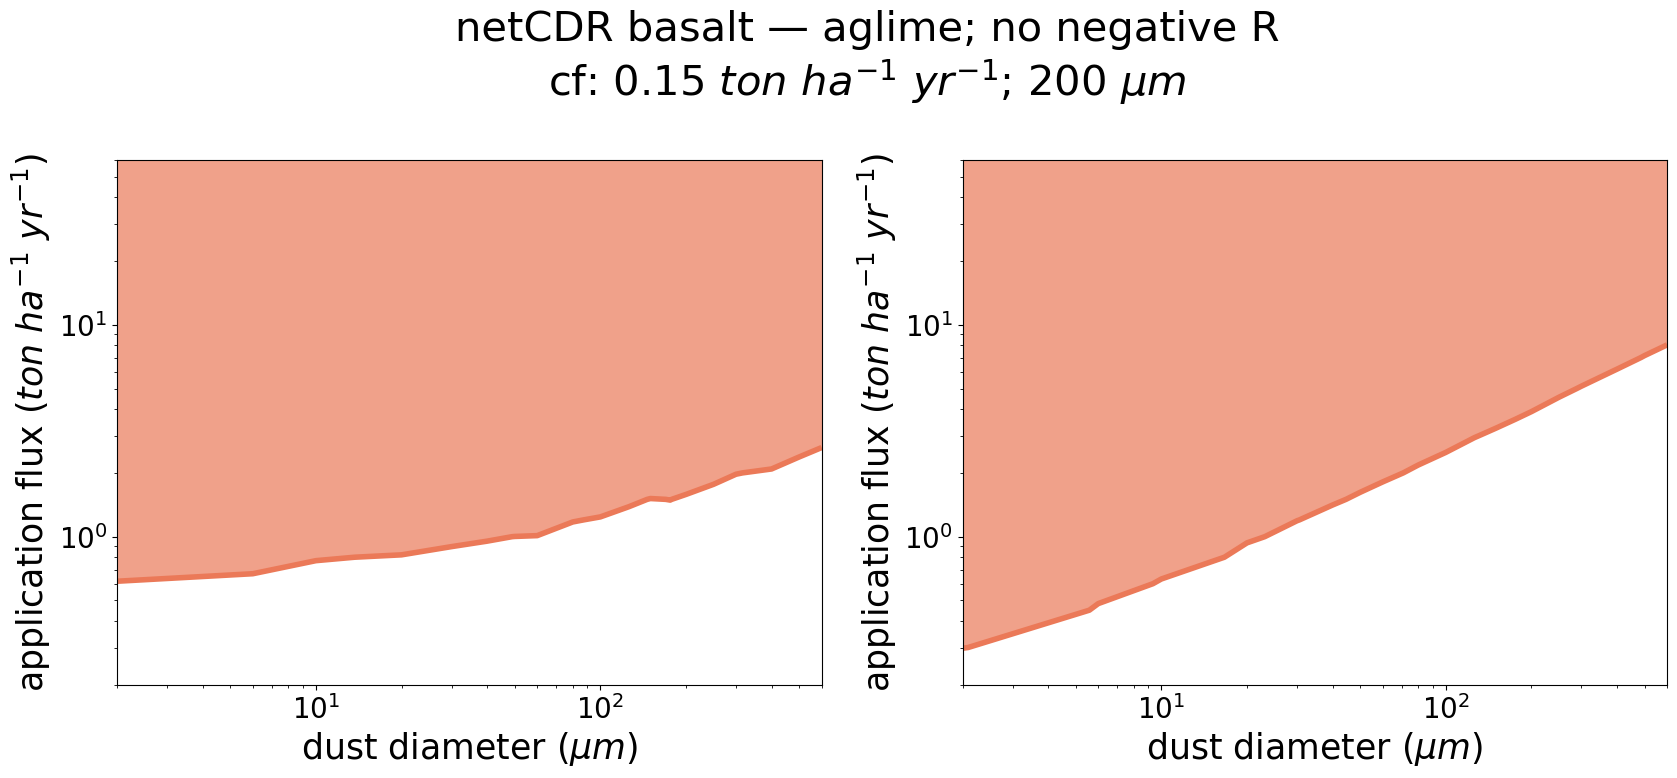

In [50]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True
show_others_ingray = False    # whether to add prior accounting approaches in gray background

cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
# cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}


# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
if show_others_ingray:
    contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf2 = plt.contourf(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0,ds1_c2.transpose().max()], colors=col[1:], alpha=0.7)
contour_line2 = plt.contour(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime; {list(cdr_calc.keys())[1]}\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
if show_others_ingray:
    contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf2 = plt.contourf(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0,ds2_c2.transpose().max()], colors=col[1:], alpha=0.7)
contour_line2 = plt.contour(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0], colors=col[1:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


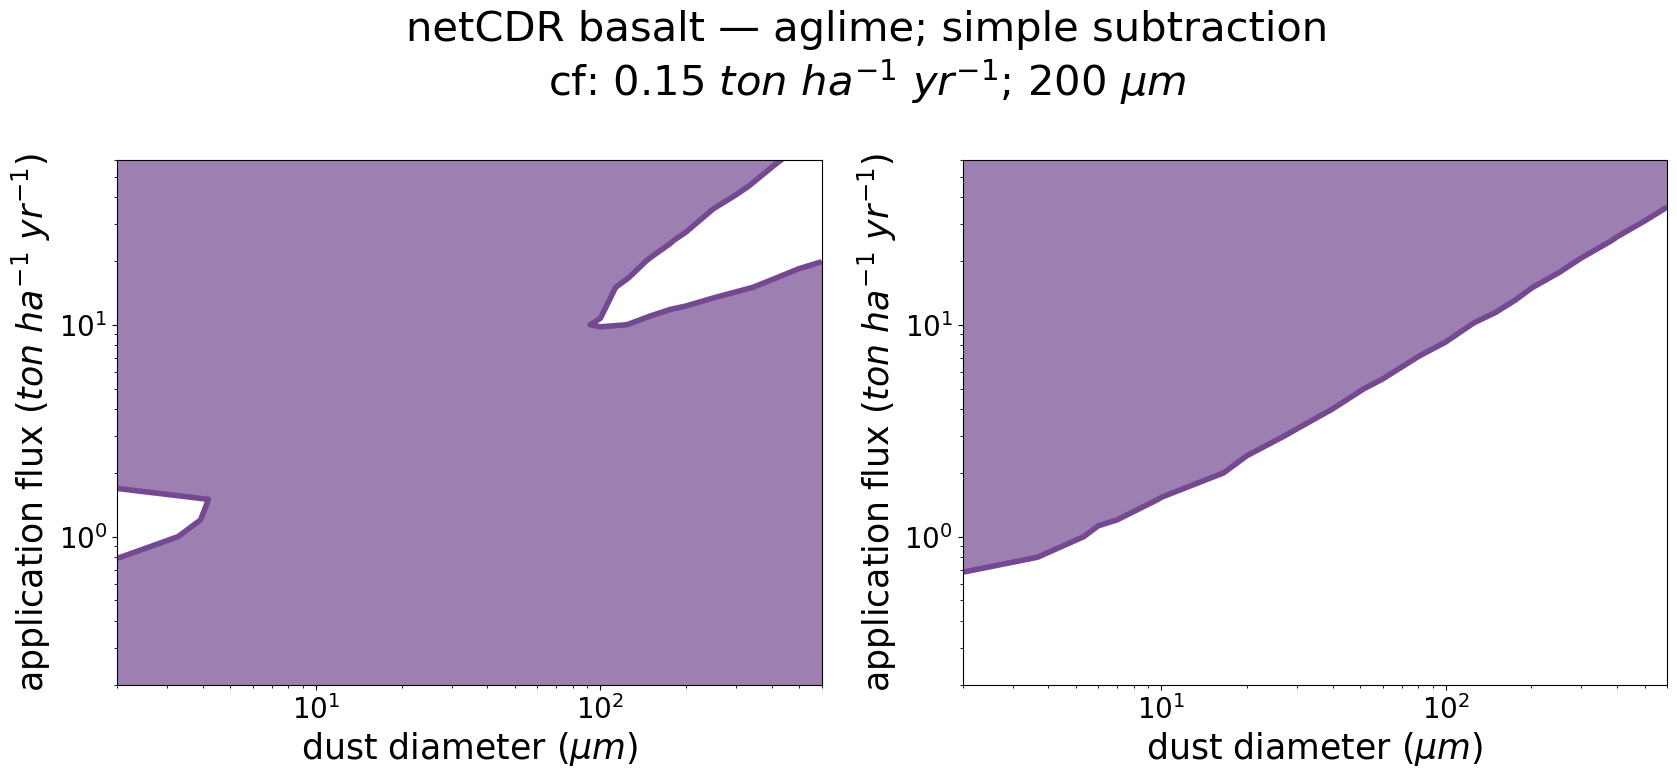

In [52]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True
show_others_ingray = False    # whether to add prior accounting approaches in gray background

cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
# cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}

# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c3 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# ds1_c4 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c3 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# ds2_c4 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c3 = ds1_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# ds1_c4 = ds1_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c3 = ds2_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# ds2_c4 = ds2_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# ... c3
x1c3 = ds1_c3['dustrad'].values
y1c3 = ds1_c3['dustrate_ton_ha_yr'].values
# ... c4
# x1c4 = ds1_c4['dustrad'].values
# y1c4 = ds1_c4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values
# ... c3
x2c3 = ds2_c3['dustrad'].values
y2c3 = ds2_c3['dustrate_ton_ha_yr'].values
# ... c4
# x2c4 = ds2_c4['dustrad'].values
# y2c4 = ds2_c4['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
if show_others_ingray:
    contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors='black', alpha=0.1)
    contourf2 = plt.contourf(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0,ds1_c2.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line2 = plt.contour(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf3 = plt.contourf(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0,ds1_c3.transpose().max()], colors=col[2:], alpha=0.7)
# contourf4 = plt.contourf(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0,ds1_c4.transpose().max()], colors=col[3:], alpha=0.2)
contour_line3 = plt.contour(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
# contour_line4 = plt.contour(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
# legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime; {list(cdr_calc.keys())[2]}\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
if show_others_ingray:
    contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors='black', alpha=0.1)
    contourf2 = plt.contourf(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0,ds2_c2.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line2 = plt.contour(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf3 = plt.contourf(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0,ds2_c3.transpose().max()], colors=col[2:], alpha=0.7)
# contourf4 = plt.contourf(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0,ds2_c4.transpose().max()], colors=col[3:], alpha=0.2)
contour_line3 = plt.contour(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0], colors=col[2:], linewidths=lwds)
# contour_line4 = plt.contour(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
# legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])

plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


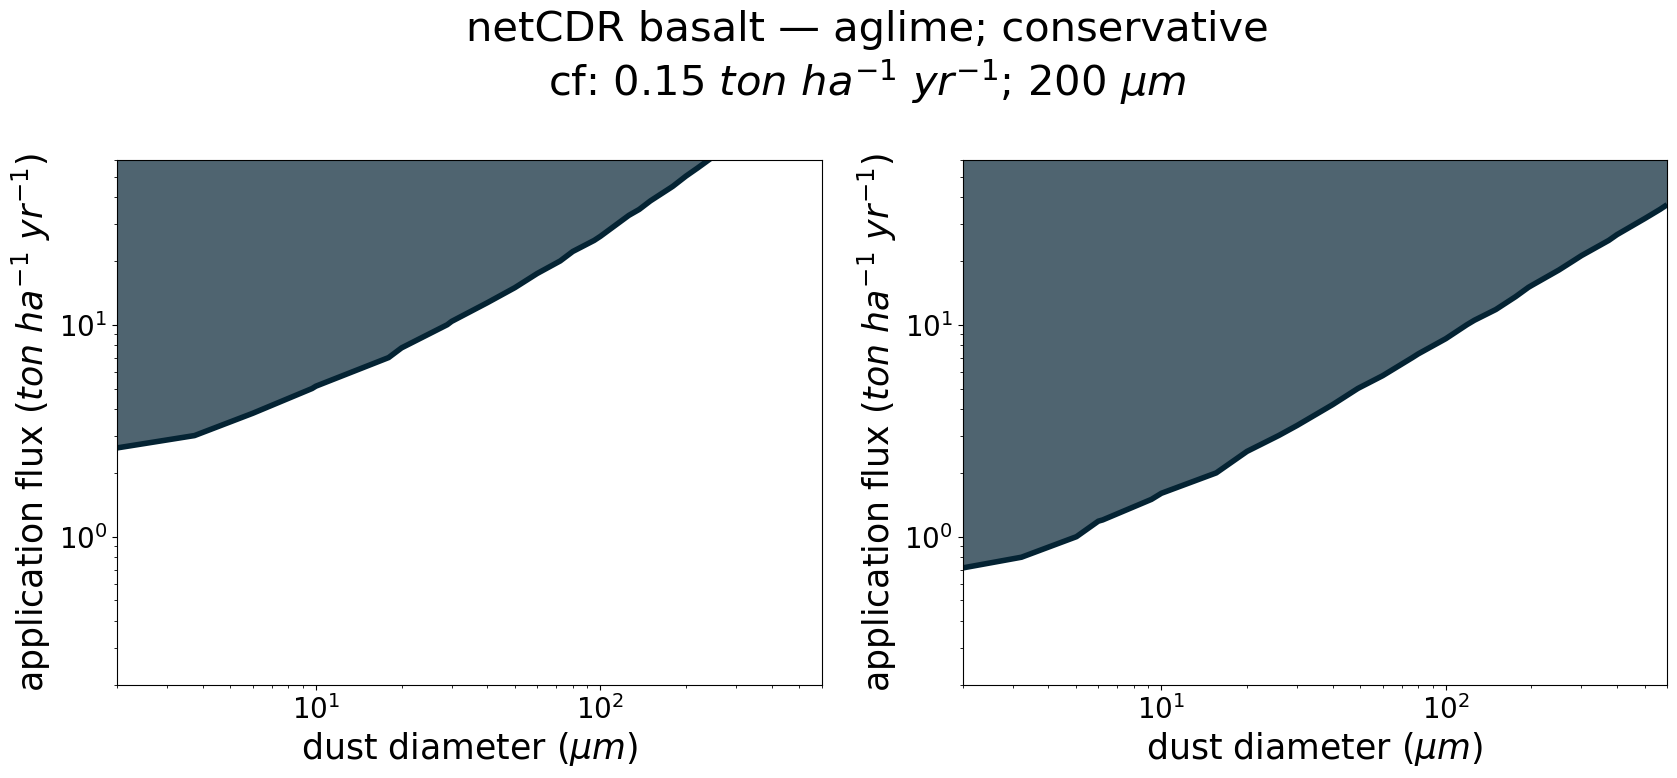

In [53]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True
show_others_ingray = False    # whether to add prior accounting approaches in gray background

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}

# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c3 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c4 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[0]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[1]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c3 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[2]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c4 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[3]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c3 = ds1_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c4 = ds1_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c3 = ds2_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c4 = ds2_c4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# ... c3
x1c3 = ds1_c3['dustrad'].values
y1c3 = ds1_c3['dustrate_ton_ha_yr'].values
# ... c4
x1c4 = ds1_c4['dustrad'].values
y1c4 = ds1_c4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values
# ... c3
x2c3 = ds2_c3['dustrad'].values
y2c3 = ds2_c3['dustrate_ton_ha_yr'].values
# ... c4
x2c4 = ds2_c4['dustrad'].values
y2c4 = ds2_c4['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
if show_others_ingray:
    contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors='black', alpha=0.1)
    contourf2 = plt.contourf(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0,ds1_c2.transpose().max()], colors='black', alpha=0.1)
    contourf3 = plt.contourf(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0,ds1_c3.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line2 = plt.contour(x1c2*2, y1c2, ds1_c2.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line3 = plt.contour(x1c3*2, y1c3, ds1_c3.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf4 = plt.contourf(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0,ds1_c4.transpose().max()], colors=col[3:], alpha=0.7)
contour_line4 = plt.contour(x1c4*2, y1c4, ds1_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime; {list(cdr_calc.keys())[3]}\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

# --- fertlevel 2
ax = plt.subplot(spec[1])
if show_others_ingray:
    contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors='black', alpha=0.1)
    contourf2 = plt.contourf(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0,ds2_c2.transpose().max()], colors='black', alpha=0.1)
    contourf3 = plt.contourf(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0,ds2_c3.transpose().max()], colors='black', alpha=0.1)
    contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line2 = plt.contour(x2c2*2, y2c2, ds2_c2.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
    contour_line3 = plt.contour(x2c3*2, y2c3, ds2_c3.transpose(),levels=[0], colors='darkgray', linewidths=lwds)
contourf4 = plt.contourf(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0,ds2_c4.transpose().max()], colors=col[3:], alpha=0.7)
contour_line4 = plt.contour(x2c4*2, y2c4, ds2_c4.transpose(),levels=[0], colors=col[3:], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[0])
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label=list(cdr_calc.keys())[1])
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label=list(cdr_calc.keys())[2])
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label=list(cdr_calc.keys())[3])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')


----
## [7] Single panel contour lines for both fert cases
- single contour line at breakeven 
- both fert cases on the same panel

**User decides:**
- feedstock
- loss rate to apply (the loss rate applies to cc and silicate)
- Type of cdr to plot
- whether to use log x and/or y

(0.2, 60)

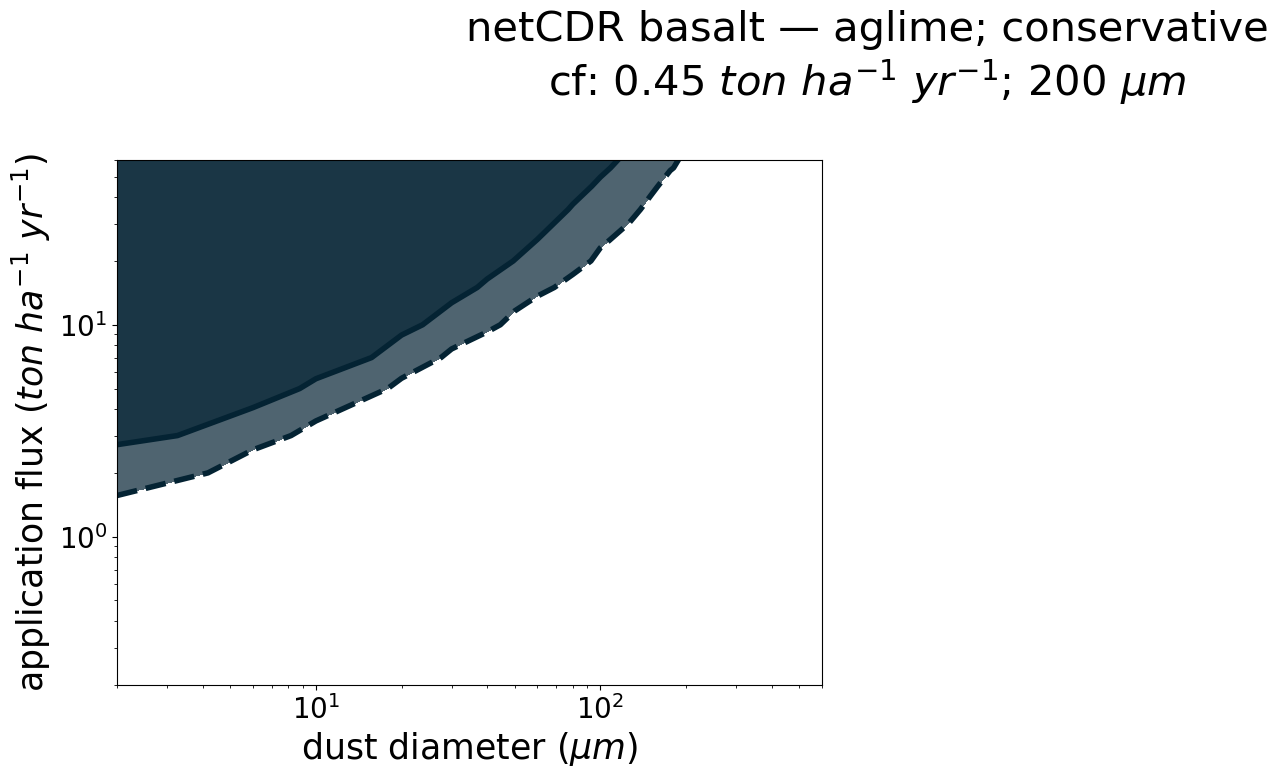

In [15]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 10
logX = True
logY = True
casedx = 3      # index for the cdr_calc case to use 

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}


# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[casedx]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc.values())[casedx]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 4))]
# include contour fill?
include_fill = True
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# ... c2
x1c2 = ds1_c2['dustrad'].values
y1c2 = ds1_c2['dustrate_ton_ha_yr'].values
# ... c3
x1c3 = ds1_c3['dustrad'].values
y1c3 = ds1_c3['dustrate_ton_ha_yr'].values
# ... c4
x1c4 = ds1_c4['dustrad'].values
y1c4 = ds1_c4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values
# ... c2
x2c2 = ds2_c2['dustrad'].values
y2c2 = ds2_c2['dustrate_ton_ha_yr'].values
# ... c3
x2c3 = ds2_c3['dustrad'].values
y2c3 = ds2_c3['dustrate_ton_ha_yr'].values
# ... c4
x2c4 = ds2_c4['dustrad'].values
y2c4 = ds2_c4['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[1, 1])
plt.figure(figsize=(20,15))

# --- both fert levels
ax = plt.subplot(spec[0])
# --- fertlevel 1
if include_fill:
    contourf11 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors=col[casedx:], alpha=0.7)
contour_line11 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors=col[casedx:], linewidths=lwds)
legend_line11 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[casedx])
# --- fertlevel 2 
if include_fill:
    contourf21 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors=col[casedx:], alpha=0.7)
contour_line21 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors=col[casedx:], linewidths=lwds, linestyles='dashed')
legend_line21 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc.keys())[casedx])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime; {list(cdr_calc.keys())[3]}\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper right')

-----
## [8a] Conservative mineral
- filled contour plot for both minerals

**User decides:**
- fertilizer case
- loss rate to apply (the loss rate applies to cc and silicate)
- Type of cdr to plot
- whether to use log x and/or y

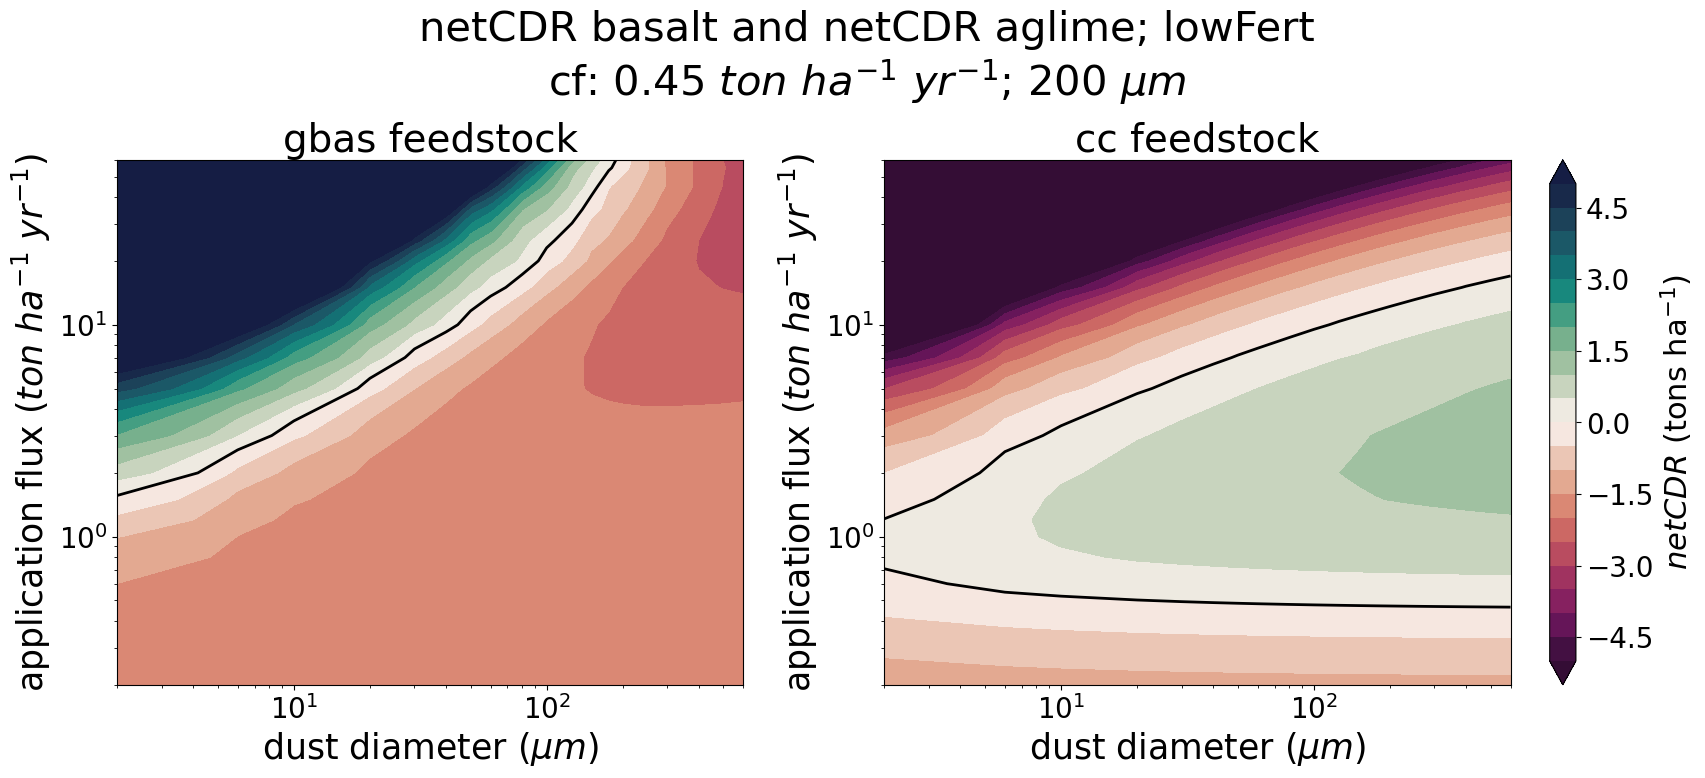

In [19]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
fertcase = 2
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative'
logX = True
logY = True

# pull out the data we want
if fertcase == 1:
    dsanom_sil = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_1
if fertcase == 2:
    dsanom_sil = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_2

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom_sil = dsanom_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc = dsanom_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [sil fs]
x1 = dsanom_sil['dustrad'].values
y1 = dsanom_sil['dustrate_ton_ha_yr'].values
# [cc fs]
x2 = dsanom_cc['dustrad'].values
y2 = dsanom_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom_sil.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fsname_sil} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom_cc.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fsname_cc} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


-----
## [8b] Conservative gbas – conservative cc
- filled contour plot 

**User decides:**
- loss rate to apply (the loss rate applies to cc and silicate)
- Type of cdr to plot
- whether to use log x and/or y

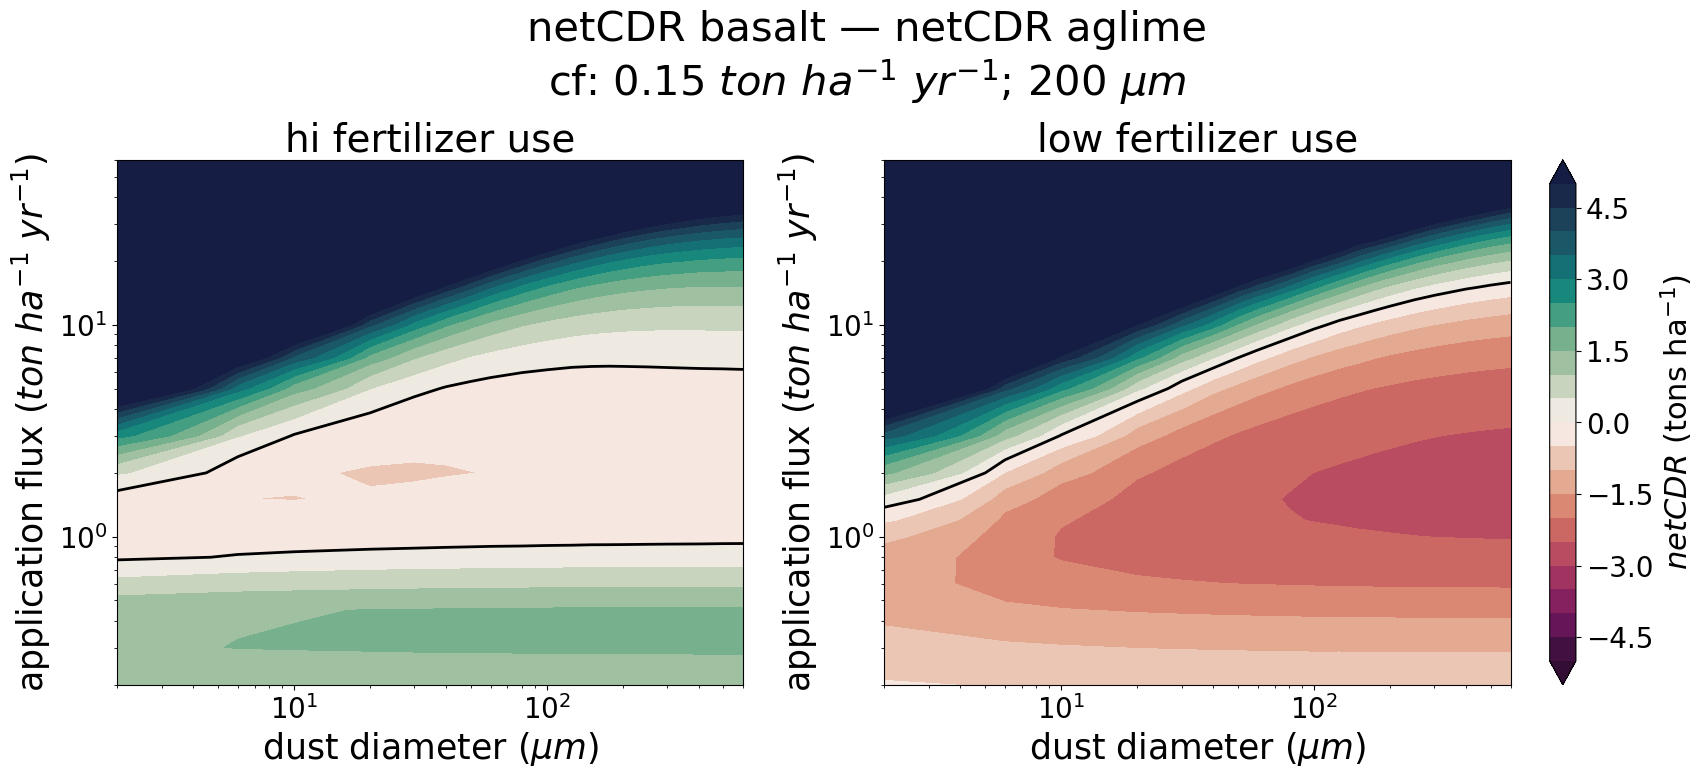

In [97]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative'
logX = True
logY = True

# pull out the data we want
dsanom1_sil = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom1_cc = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_sil = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_cc = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_sil = dsanom1_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom1_cc = dsanom1_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_sil = dsanom2_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_cc = dsanom2_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# get difference
ds1_sil_cc = dsanom1_sil - dsanom1_cc
ds2_sil_cc = dsanom2_sil - dsanom2_cc

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = ds1_sil_cc['dustrad'].values
y1 = ds1_sil_cc['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = ds2_sil_cc['dustrad'].values
y2 = ds2_sil_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,ds1_sil_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,ds1_sil_cc.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — netCDR aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,ds2_sil_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,ds2_sil_cc.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


----
# [X] Compare rock dissolution (sil vs aglime)

**User decides:**
- fertlevel

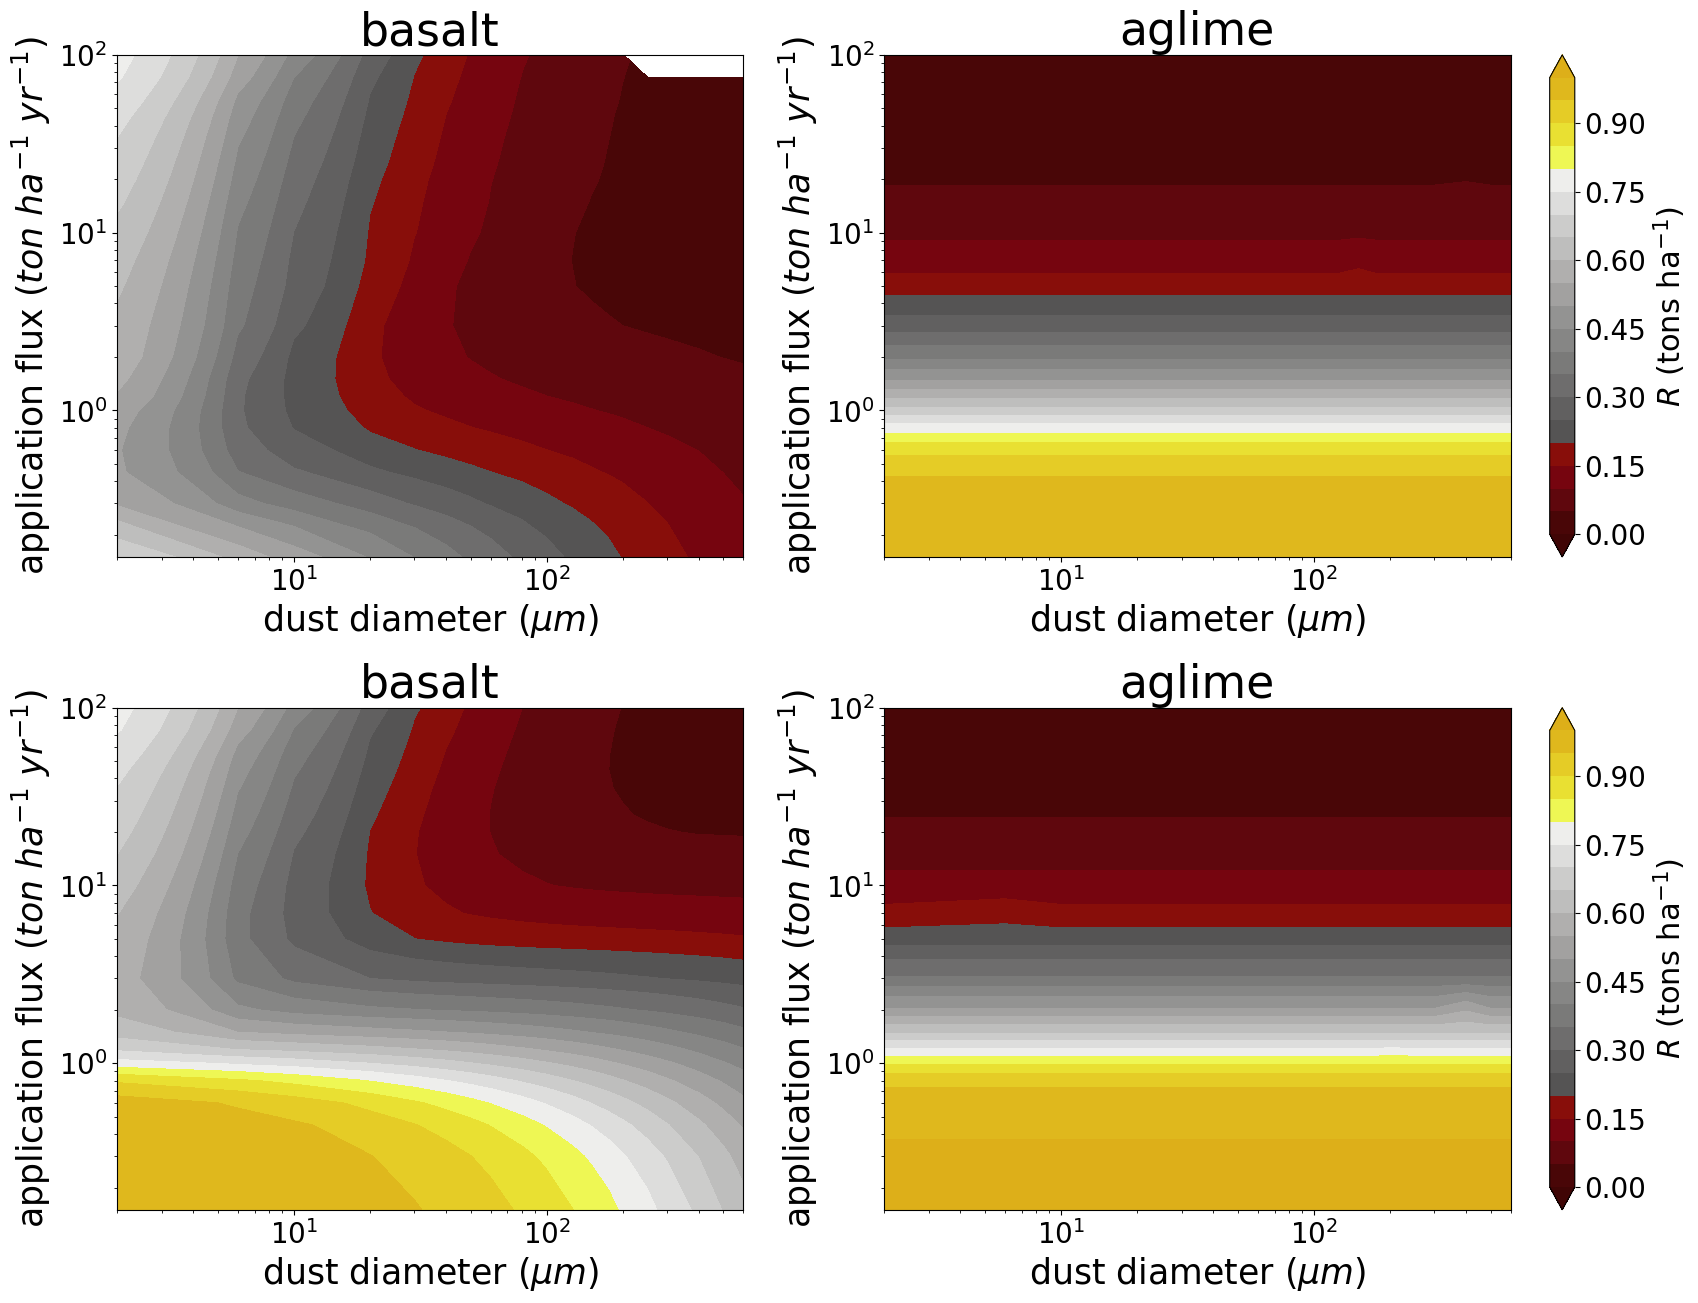

In [23]:
# --- PLOT --------------------
# set data conditions
pvar = 'fraction_remaining_dissolved' # 'fraction_total_dissolved'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar]
dssil2_p3 = dssil2[pvar]
dscc1_p3 = dscc1[pvar]
dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.oxy
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0, 1
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

----
# [X] Compare secondary mineral loss

**User decides:**
- fertlevel

In [81]:
tot_adv

<xarray.Dataset> Size: 1MB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 21,
                                   dustrad: 19)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 168B 0.15 ... ...
  * dustrad                       (dustrad) int32 76B 1 3 5 10 ... 200 250 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    ...                            ...
    time_horizon                  float64 8B 15.0
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

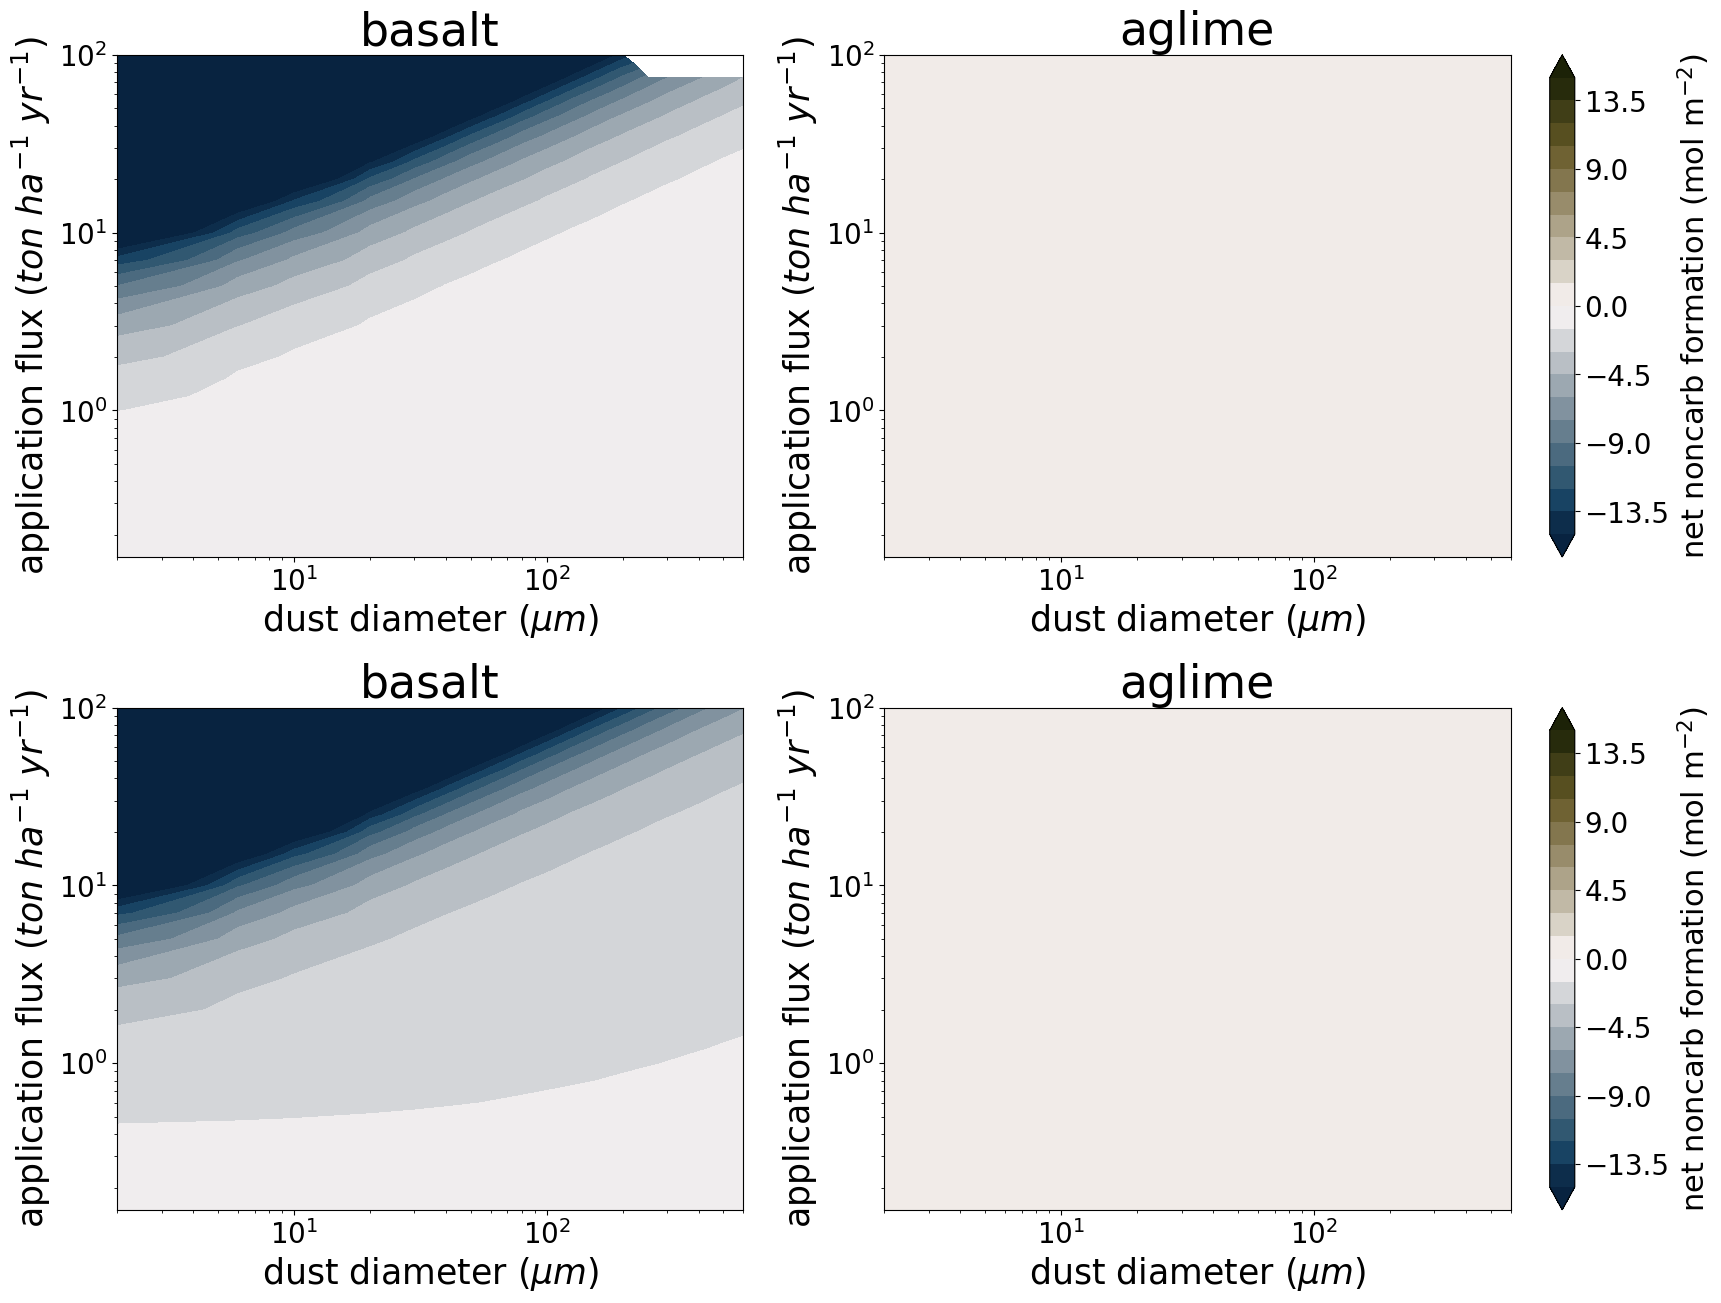

In [92]:
# --- PLOT --------------------
# set data conditions
carb_or_noncarb = 'noncarb'
pvar1, pvar2 = f'{carb_or_noncarb}sld_source_mg', f'{carb_or_noncarb}sld_source_ca'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar1] # + dssil1[pvar2]
dssil2_p3 = dssil2[pvar1] # + dssil2[pvar2]
dscc1_p3 = dscc1[pvar1] # + dscc1[pvar2]
dscc2_p3 = dscc2[pvar1] # + dscc2[pvar2]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.diff
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -15, 15
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

In [ ]:
# ----------------------------------------------------

----
# [X] SCRATCH

### Compare CDR for aglime and basalt for constant alkalinity flux
1. Flatten the alkalinity flux and R data into 1D for both datasets
2. Find the places where alkalinity flux of ds2 is within X% of ds1
3. Pull out the R data for the places where alkalinity is the same
4. Compute R_cc / R_sil

In [3]:
def find_matching_cdr_all(dssil, dscc, cation_dat, cdrvar, loss_percent, tolerance=0.1):
    dssil = dssil.sel(loss_percent = loss_percent, method='nearest').copy()
    dscc = dscc.sel(loss_percent = loss_percent, method='nearest').copy()
    # flatten data
    advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrsil = dssil[cdrvar].values.flatten()
    advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrcc = dscc[cdrvar].values.flatten()
    # flatten coords
    dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='xy')
    dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='xy')
    dratesil = dratesil.flatten()
    dradsil = dradsil.flatten()
    dratecc = dratecc.flatten()
    dradcc = dradcc.flatten()

    # loop through
    results = []
    idxsil = 0
    for asil, csil in zip(advsil, cdrsil):
        # Find matching indices in the second dataset
        mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
        if np.any(mask):
            # matching_adv = advcc[mask]
            # matching_cdr = cdrcc[mask]
            for j in np.where(mask)[0]:
                results.append({
                    'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': advcc[j], 'cdr_cc': cdrcc[j],
                    'dustrate_sil': dratesil[idxsil], 'dustrad_sil': dradsil[idxsil], 
                    'dustrate_cc': dratecc[j], 'dustrad_cc': dradcc[j]
                })
            # for acc, ccc in zip(matching_adv, matching_cdr):
            #     results.append({
            #         'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': acc, 'cdr_cc': ccc,
            #         'dustrate_sil': 
            #     })
        else:
            results.append({
                'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
                'dustrate_sil': None, 'dustrad_sil': None, 
                'dustrate_cc': None, 'dustrad_cc': None
            })
        idxsil += 1
        
    outdf = pd.DataFrame(results)

    return outdf


In [4]:
def find_matching_cdr_mean(dssil, dscc, cation_dat, cdrvar, loss_percent, tolerance=0.1):
    # in the other fxn, we take dssil_adv and save every single cc pixel within tolerance
    # here, we just take the mean of every pixel within tolerance
    
    dssil = dssil.sel(loss_percent = loss_percent, method='nearest').copy()
    dscc = dscc.sel(loss_percent = loss_percent, method='nearest').copy()
    # flatten data
    advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrsil = dssil[cdrvar].values.flatten()
    advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrcc = dscc[cdrvar].values.flatten()
    # flatten coords
    dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='xy')
    dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='xy')
    dratesil = dratesil.flatten()
    dradsil = dradsil.flatten()
    dratecc = dratecc.flatten()
    dradcc = dradcc.flatten()

    # loop through
    results = []
    for asil, csil in zip(advsil, cdrsil):
        # Find matching indices in the second dataset
        mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
        if np.any(mask):
            results.append({
                    'adv_sil': asil, 'cdr_sil': csil, 
                    'adv_cc': np.nanmean(advcc[mask]), 'cdr_cc': np.nanmean(cdrcc[mask]),
                    'dustrate_sil': np.nanmean(dratesil[mask]), 'dustrad_sil': np.nanmean(dradsil[mask]), 
                    'dustrate_cc': np.nanmean(dratecc[mask]), 'drad_cc': np.nanmean(dradcc[mask])
                })
        else:
            results.append({
                'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
                'dustrate_sil': None, 'dustrad_sil': None, 
                'dustrate_cc': None, 'drad_cc': None
            })
        
    outdf = pd.DataFrame(results)

    return outdf


In [9]:
# --- decide the cation data to use
cation_dat = "totcat"    # ["totcat" | "camg"]
# --- decide the CDR variable to use
cdrvar = "cdr_adv" 
# --- select the loss percent
loss_percent = 15
# --- set tolerance
tol = 0.02

df1 = find_matching_cdr_all(dssil1, dscc1, cation_dat, cdrvar, loss_percent, tolerance=tol)
df1['Rcc_Rsil'] = df1['cdr_cc'] / df1['cdr_sil']
df2 = find_matching_cdr_all(dssil2, dscc2, cation_dat, cdrvar, loss_percent, tolerance=tol)
df2['Rcc_Rsil'] = df2['cdr_cc'] / df2['cdr_sil']

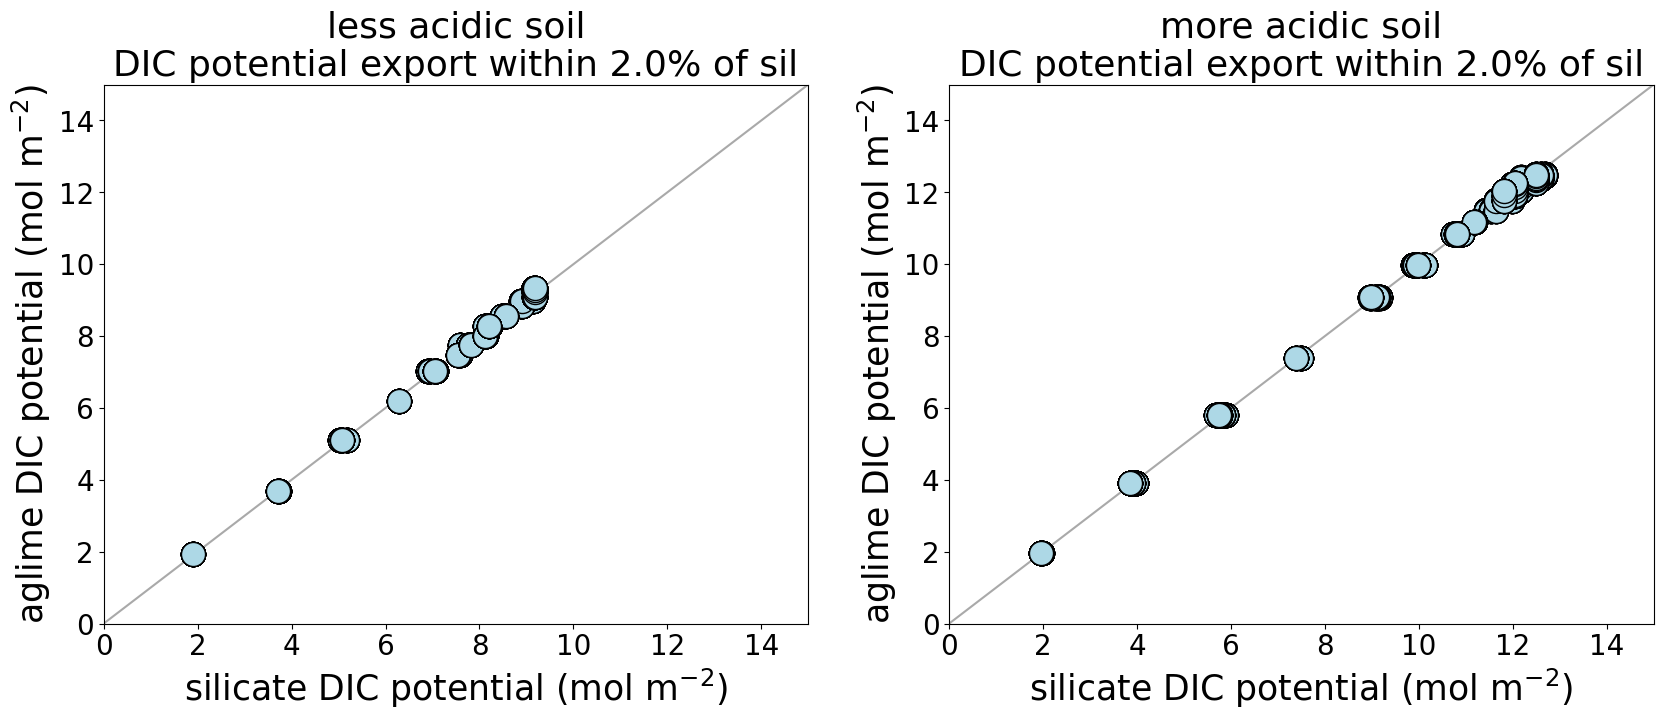

In [10]:
# --- PLOT advection CC vs Sil to confirm the comparison worked ! 

# --- plot aesthetics
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 26    # plot title
# point sizes
ptsize = 300
# axis limits
xmin, xmax = 0, 15
ymin, ymax = 0, 15
# *****************************

spec = GridSpec(ncols=2, nrows=1, hspace=0.3, width_ratios=[1, 1])
plt.figure(figsize=(20,7))

# fert level 1
ax = plt.subplot(spec[1])
plt.plot([xmin, xmax], [ymin, ymax], color='darkgray', zorder=0)
plt.scatter(df1['adv_sil'], df1['adv_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.xlabel(r"silicate DIC potential $(\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.ylabel(r"aglime DIC potential $(\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.title(f"more acidic soil\nDIC potential export within {tol*100}% of sil", fontsize=fs_title)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax);

# fert level 2
ax = plt.subplot(spec[0])
plt.plot([xmin, xmax], [ymin, ymax], color='darkgray',zorder=0)
plt.scatter(df2['adv_sil'], df2['adv_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.xlabel(r"silicate DIC potential $(\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.ylabel(r"aglime DIC potential $(\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.title(f"less acidic soil\nDIC potential export within {tol*100}% of sil", fontsize=fs_title)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax);

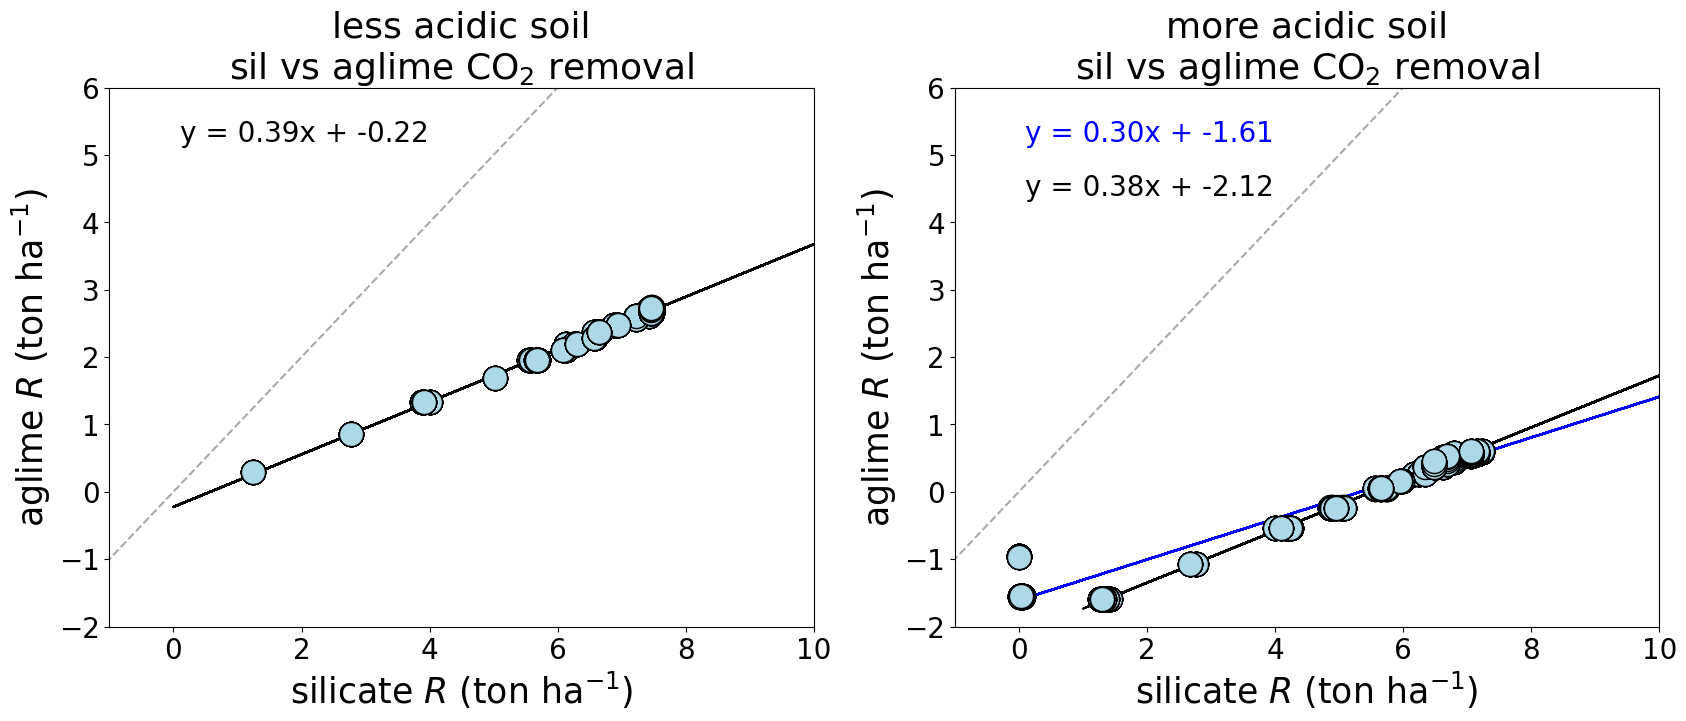

In [11]:
# --- PLOT cdr results to get a line of best fit

# --- plot aesthetics
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 26    # plot title
fs_regression = 20
# point sizes
ptsize = 300
# axis limits
xmin, xmax = -1, 10
ymin, ymax = -2, 6
# *****************************

# -----------------------------
# --- fit lines (first order fit)
# # [fertlevel 1]
valid_idx1 = ~np.isnan(df1['cdr_sil']) & ~np.isnan(df1['cdr_cc'])
slope1, intercept1 = np.polyfit(df1['cdr_sil'][valid_idx1], df1['cdr_cc'][valid_idx1], 1)
yfit1 = slope1 * df1['cdr_sil'] + intercept1
line_label1 = f"y = {slope1:.2f}x + {intercept1:.2f}"

df1_cut = df1[df1['cdr_sil'] > 1].copy()
valid_idx1_cut = ~np.isnan(df1_cut['cdr_sil']) & ~np.isnan(df1_cut['cdr_cc'])
slope1_cut, intercept1_cut = np.polyfit(df1_cut['cdr_sil'][valid_idx1_cut], df1_cut['cdr_cc'][valid_idx1_cut], 1)
yfit1_cut = slope1_cut * df1_cut['cdr_sil'] + intercept1_cut
line_label1_cut = f"y = {slope1_cut:.2f}x + {intercept1_cut:.2f}"

# # [fertlevel 2]
valid_idx2 = ~np.isnan(df2['cdr_sil']) & ~np.isnan(df2['cdr_cc'])
slope2, intercept2 = np.polyfit(df2['cdr_sil'][valid_idx2], df2['cdr_cc'][valid_idx2], 1)
yfit2 = slope2 * df2['cdr_sil'] + intercept2
line_label2 = f"y = {slope2:.2f}x + {intercept2:.2f}"
# -----------------------------

spec = GridSpec(ncols=2, nrows=1, hspace=0.3, width_ratios=[1, 1])
plt.figure(figsize=(20,7))

# fert level 1
ax = plt.subplot(spec[1])
plt.plot([-10,15], [-10, 15], color='darkgray', zorder=0, linestyle='dashed')
# fit line and label
plt.plot(df1['cdr_sil'], yfit1, color='blue', zorder=1)
plt.text(0.1, 0.9, line_label1, transform=plt.gca().transAxes, fontsize=fs_regression, color='blue')
plt.plot(df1_cut['cdr_sil'], yfit1_cut, color='black', zorder=1)
plt.text(0.1, 0.8, line_label1_cut, transform=plt.gca().transAxes, fontsize=fs_regression, color='black')
# scatterplot
plt.scatter(df1['cdr_sil'], df1['cdr_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.xlabel(r"silicate $R\ (\text{ton}\ \text{ha}^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"aglime $R\ (\text{ton}\ \text{ha}^{-1})$", fontsize=fs_xlab)
plt.title(f"more acidic soil\nsil vs aglime {r"$\text{CO}_2$"} removal", fontsize=fs_title)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax);

# fert level 2
ax = plt.subplot(spec[0])
plt.plot([-10,15], [-10, 15], color='darkgray', zorder=0, linestyle='dashed')
# fit line and label (full data)
plt.plot(df2['cdr_sil'], yfit2, color='black', zorder=1)
plt.text(0.1, 0.9, line_label2, transform=plt.gca().transAxes, fontsize=fs_regression, color='black')
# scatterplot
plt.scatter(df2['cdr_sil'], df2['cdr_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.xlabel(r"silicate $R\ (\text{ton}\ \text{ha}^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"aglime $R\ (\text{ton}\ \text{ha}^{-1})$", fontsize=fs_xlab)
plt.title(f"less acidic soil\nsil vs aglime {r"$\text{CO}_2$"} removal", fontsize=fs_title)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax);

<Figure size 2000x2000 with 0 Axes>

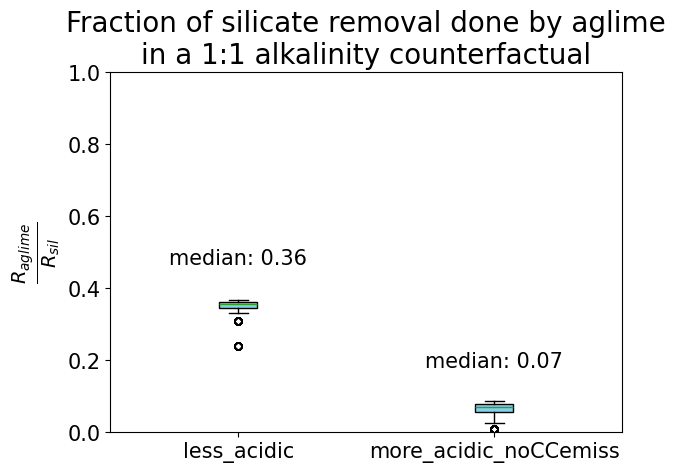

In [12]:
# --- PLOT bar charts for Rcc / Rsil
# remove the values that blow up in df1 (these are places where there's so much strong acid that there's no removal anyway)
df1x = df1[(df1['cdr_sil'] > 0.5)].copy()
df1x_pos = df1[(df1['cdr_sil'] > 0.5) & (df1['cdr_cc'] > 0)].copy()

# combine the two dataframes together
df2['exp'] = 'less_acidic'
df1x['exp'] = 'more_acidic'
df1x_pos['exp'] = 'more_acidic_noCCemiss'
dfplot = pd.concat([df2, df1x_pos], axis=0, ignore_index=True)


# --- plot aesthetics
# set fontsizes
fs_xlab = 20     # x title
fs_ylab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 20    # plot title
# *****************************


# --- plot 
plt.figure(figsize=(20,20))
box = dfplot.boxplot(column='Rcc_Rsil', by='exp', grid=False, patch_artist=True, 
           boxprops=dict(facecolor='skyblue', color='black'),
           whiskerprops=dict(color='black'),
           flierprops=dict(marker='o', color='red', markersize=5),
           # meanline=True, showmeans=True
           )
plt.ylim(0, 1)
plt.ylabel(r"$\frac{R_{aglime}}{R_{sil}}$", fontsize=fs_xlab)
plt.xlabel("")
plt.title("Fraction of silicate removal done by aglime\nin a 1:1 alkalinity counterfactual", fontsize=fs_title)
plt.suptitle('')
plt.tick_params(axis='both', labelsize=fs_tick)

# add labels for median values
for i in range(2):
    # Calculate the median for each experiment group
    median_value = dfplot.groupby('exp')['Rcc_Rsil'].median().iloc[i]
    
    # Get the position above the box to place the label
    x_position = i + 1  # x position is the group number (1-indexed for plot)
    plt.text(x_position, median_value + 0.1, f'median: {median_value:.2f}', ha='center', va='bottom', color='black', fontsize=15)




Text(0, 0.5, 'dustrad')

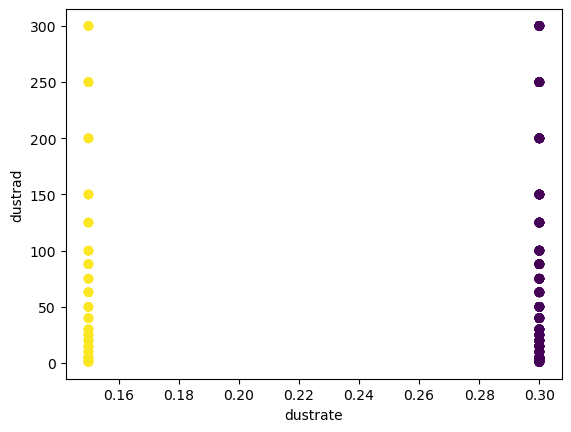

In [49]:
# --- investigate the weird values where sil cdr reaches zero!
dfx = df1[(df1['cdr_sil'] < 0.5) & (df1['cdr_cc'] < 0)].copy()

plt.scatter(dfx['dustrate_cc'], dfx['dustrad_cc'], c=dfx['cdr_cc'], cmap='viridis')
plt.xlabel('dustrate')
plt.ylabel('dustrad')

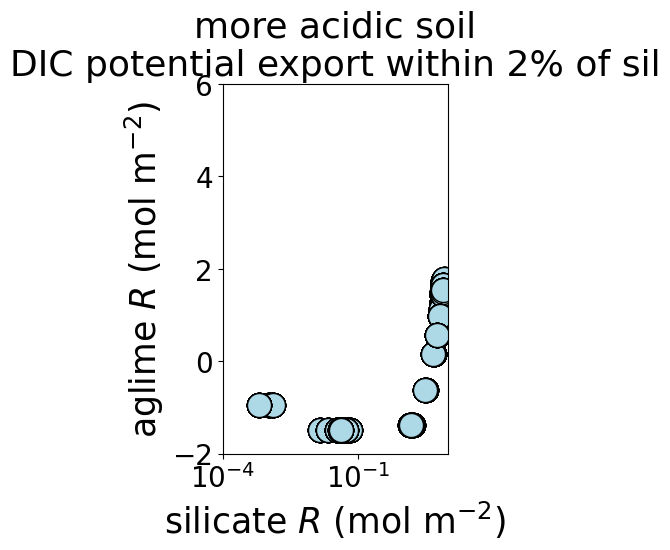

In [54]:
# fert level 1
ax = plt.subplot(spec[0])
# scatterplot
plt.scatter(df1['cdr_sil'], df1['cdr_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.xlabel(r"silicate $R\ (\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.ylabel(r"aglime $R\ (\text{mol}\ \text{m}^{-2})$", fontsize=fs_xlab)
plt.title("more acidic soil\nDIC potential export within 2% of sil", fontsize=fs_title)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(0.0001, 10)
plt.xscale('log')
plt.ylim(ymin, ymax);

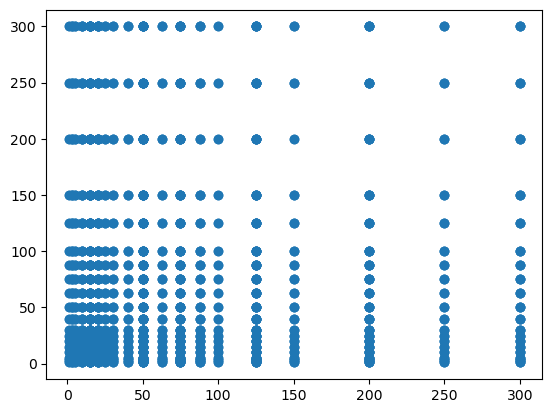

In [128]:
# --- silicate dustrate vs ag dustrate
plt.scatter(df1['dustrad_sil'], df1['dustrad_cc'])

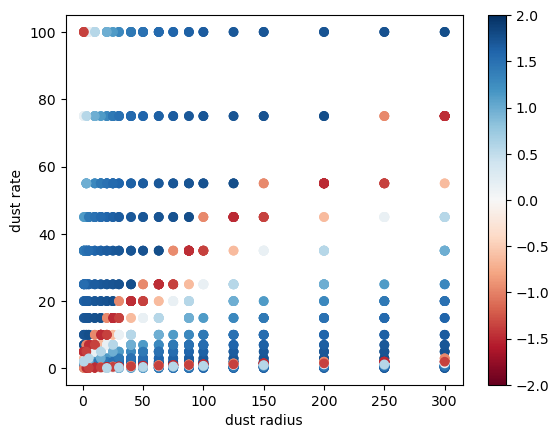

In [30]:
plt.scatter(df1['dustrad_cc'], df1['dustrate_cc'], c=df1['cdr_cc'], cmap='RdBu', vmin=-2, vmax=2)
plt.xlabel('dust radius')
plt.ylabel('dust rate')
plt.colorbar()

In [42]:

dssil = dssil1.sel(loss_percent = loss_percent, method='nearest').copy()
dscc = dscc1.sel(loss_percent = loss_percent, method='nearest').copy()


# flatten data
advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
cdrsil = dssil[cdrvar].values.flatten()
advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
cdrcc = dscc[cdrvar].values.flatten()
# flatten coords
dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='xy')
dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='xy')
dratesil = dratesil.flatten()
dradsil = dradsil.flatten()
dratecc = dratecc.flatten()
dradcc = dradcc.flatten()

# loop through
# results = []
# for asil, csil in zip(advsil, cdrsil):
#     # Find matching indices in the second dataset
#     mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
#     if np.any(mask):
#         # matching_adv = advcc[mask]
#         # matching_cdr = cdrcc[mask]
#         for j in np.where(mask)[0]:
#             results.append({
#                 'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': advcc[j], 'cdr_cc': cdrcc[j],
#                 'dustrate_sil': dratesil[j], 'dustrad_sil': dradsil[j], 
#                 'dustrate_cc': dratecc[j], 'dustrad_cc': dradcc[j]
#             })
#         # for acc, ccc in zip(matching_adv, matching_cdr):
#         #     results.append({
#         #         'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': acc, 'cdr_cc': ccc,
#         #         'dustrate_sil': 
#         #     })
#     else:
#         results.append({
#             'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
#             'dustrate_sil': None, 'dustrad_sil': None, 
#             'dustrate_cc': None, 'dustrad_cc': None
#         })
    
# outdf = pd.DataFrame(results)

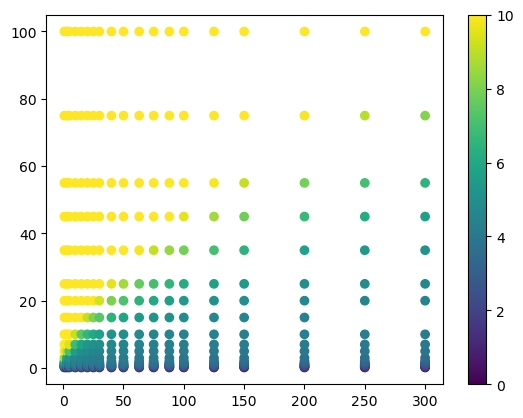

In [43]:
# advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
# cdrsil = dssil[cdrvar].values.flatten()
# advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
# cdrcc = dscc[cdrvar].values.flatten()
# # flatten coords
# dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='ij')
# dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='ij')
# dratesil = dratesil.flatten()
# dradsil = dradsil.flatten()
# dratecc = dratecc.flatten()
# dradcc = dradcc.flatten()

plt.scatter(dradsil, dratesil, c=advsil, vmin=0, vmax=10)
plt.colorbar()


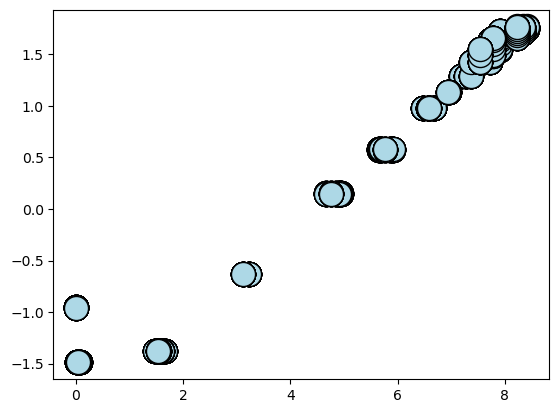

In [40]:
# plt.scatter(df2['dustrad_sil'], df2['cdr_sil']-df2['cdr_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
plt.scatter(df1['cdr_sil'], df1['cdr_cc'], facecolor='lightblue', edgecolor='black', s=ptsize)
# df2

(-1.0, 1.0)

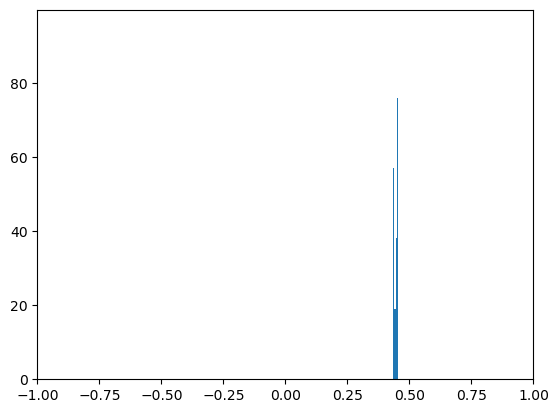

In [74]:
plt.hist(df_adv[(df_adv['Rcc_Rsil'] >= -1) & (df_adv['Rcc_Rsil'] <= 1)]['Rcc_Rsil'])
plt.xlim([-1,1])
# plt.scatter(df_adv['cdr_sil'], df_adv['cdr_cc'])
# plt.plot([0, 15], [0, 15])

In [75]:
df_adv[(df_adv['Rcc_Rsil'] >= -1) & (df_adv['Rcc_Rsil'] <= 1)]['Rcc_Rsil']

9      0.449139
10     0.449140
11     0.449143
12     0.449141
13     0.449135
         ...   
847    0.436780
848    0.436775
849    0.436788
850    0.436786
851    0.436784
Name: Rcc_Rsil, Length: 473, dtype: float64

In [46]:
tolerance = 0.1


# [1] --- flatten data
advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
cdrsil = dssil[cdrvar].values.flatten()
advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
cdrcc = dscc[cdrvar].values.flatten()
# flatten coords
dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='ij')
dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='ij')
dratesil = dratesil.flatten()
dradsil = dradsil.flatten()
dratecc = dratecc.flatten()
dradcc = dradcc.flatten()

# loop through
results = []
for asil, csil in zip(advsil, cdrsil):
    # Find matching indices in the second dataset
    mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
    if np.any(mask):
        # matching_adv = advcc[mask]
        # matching_cdr = cdrcc[mask]
        for j in np.where(mask)[0]:
            results.append({
                'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': advcc[j], 'cdr_cc': cdrcc[j],
                'dustrate_sil': dratesil[j], 'dustrad_sil': dradsil[j], 
                'dustrate_cc': dratecc[j], 'drad_cc': dradcc[j]
            })
        # for acc, ccc in zip(matching_adv, matching_cdr):
        #     results.append({
        #         'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': acc, 'cdr_cc': ccc,
        #         'dustrate_sil': 
        #     })
    else:
        results.append({
            'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
            'dustrate_sil': None, 'dustrad_sil': None, 
            'dustrate_cc': None, 'drad_cc': None
        })
    
outdf = pd.DataFrame(results)

return outdf


,adv_sil,cdr_sil,adv_cc,cdr_cc,dustrate_sil,dustrad_sil,dustrate_cc,drad_cc
0,0.914004,0.001083,NaN,NaN,NaN,NaN,NaN,NaN
1,1.813040,0.001259,1.970566,-0.955857,0.15,1.0,0.15,1.0
2,1.813040,0.001259,1.970502,-0.954228,0.30,5.0,0.30,5.0
3,1.813040,0.001259,1.970499,-0.957419,0.45,15.0,0.45,15.0
4,1.813040,0.001259,1.970485,-0.955201,0.60,25.0,0.60,25.0
...,...,...,...,...,...,...,...,...
8541,9.985733,5.768088,10.836427,0.979307,75.00,10.0,75.00,10.0
8542,9.985733,5.768088,9.074332,0.149667,100.00,5.0,100.00,5.0
8543,9.985733,5.768088,9.983093,0.577053,100.00,10.0,100.00,10.0
8544,9.985733,5.768088,10.446086,0.797866,100.00,15.0,100.00,15.0


In [45]:
dssil

<xarray.Dataset> Size: 128kB
Dimensions:                       (dustrate_ton_ha_yr: 21, dustrad: 19)
Coordinates:
    loss_percent                  float64 8B 1.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 168B 0.15 ... ...
  * dustrad                       (dustrad) int32 76B 1 3 5 10 ... 200 250 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr) float64 3kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr) float64 3kB 0...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr) float64 3kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr) float64 3kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr) float64 3kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr) float64 3kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

In [ ]:
# ----------------------------------------

In [ ]:
def find_matching_evap(precip1, evap1, precip2, evap2, tolerance=0.1):
    results = []
    for p1, e1 in zip(precip1, evap1):
        # Find matching indices in the second dataset
        mask = (precip2 >= p1 * (1 - tolerance)) & (precip2 <= p1 * (1 + tolerance))
        if np.any(mask):  # Check if there are any matches
            matching_precip = precip2[mask]
            matching_evap = evap2[mask]
            for p2, e2 in zip(matching_precip, matching_evap):
                results.append({'precip1': p1, 'evap1': e1, 'precip2': p2, 'evap2': e2})
        else:  # No matches
            results.append({'precip1': p1, 'evap1': e1, 'precip2': None, 'evap2': None})
    return results

In [27]:
cdr2.shape

(19950,)

In [7]:
dssil

<xarray.Dataset> Size: 1MB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 21,
                                   dustrad: 19)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 168B 0.15 ... ...
  * dustrad                       (dustrad) int32 76B 1 3 5 10 ... 200 250 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 160kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

In [ ]:
# [1] --- flatten data
dssil1

In [ ]:
# FERT LEVEL 1 
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))

# FERT LEVEL 2
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
